<a href="https://colab.research.google.com/github/YaninaK/predictive-maintenance/blob/main/notebooks/02_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модель раннего обнаружения неисправностей промышленного оборудования
## Исследователский анализ данных

#### [Чтение и предварительная очистка данных](https://colab.research.google.com/drive/1UHlDhDV11MuN3C4U-KqpJP736KmudnyA?usp=sharing)

ОПИСАНИЕ ЗАДАЧИ

Разработать модель, определяющую возможность возникновения нештатной работы оборудования на временном горизонте не менее 3 часов до аварийного простоя.

[РЕСУРСЫ](https://drive.google.com/file/d/1jrbfHULbZuCnwJQwNllQUFlCGpR_lHDc/view?usp=sharing)

Наборы обезличенных данных из внутренних систем ПАО «Северсталь», содержащие:
* Перечень нештатных событий, приведших к остановке линии;
* Перечень нештатных событий, повлекших деградацию функций агрегатов;
* Перечень сигналов с датчиков, контроллеров.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/YaninaK/predictive-maintenance.git -q
!pip install -r predictive-maintenance/requirements_Colab.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
%cd /content/predictive-maintenance

/content/predictive-maintenance


In [5]:
import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "src", "predictive_maintenance"))

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import missingno as msno

from data.make_dataset import load_X
from data.EDA_utilities import get_y_summary, load_y
from data.ethalon_periods import (
    select_ethalon_periods, generate_ethalon_dataset,
)
from data.stoppages import get_M1_dataset_and_time_label
from data.anomalies import get_M3_dataset, generate_targets
from data.train_test_datasets import (
    combine_test_intervals, generate_test_dataset
)
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
PATH = '/content/drive/MyDrive/ML_projects/02_Predictive_maintenance/'
FOLDER = "data/02_intermediate/"

### 1. Загрузка данных

In [9]:
messages = pd.read_parquet(PATH + FOLDER + "messages_unified.parquet")

print(f'messages.shape = {messages.shape}\n')
messages.head(2)

messages.shape = (981, 11)



МАШИНА         ИМЯ_МАШИНЫ               ТЕХ_МЕСТО  \
390         AA2/006-006  ЭКСГАУСТЕР А/М №9     AA2/006-006-002-008   
391  CH-AGP-AG2/011-005  ЭКСГАУСТЕР А/М №9  CH-AGP-AG2/011-005-002   

                      НАЗВАНИЕ_ТЕХ_МЕСТА ВИД_СООБЩЕНИЯ              ОПИСАНИЕ  \
390     ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №9            M3  неисправен двигатель   
391  МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ. №9            M3  неисправен двигатель   

    ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ  \
390       2019-01-21 00:00:00                    2019-02-25   
391       2019-01-21 12:26:08                    2019-02-25   

    ТЕКСТ_ГРУППЫ_КОДОВ equipment                        unified_name  
390               None         9     ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №  
391               None         9  МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ_ №

In [10]:
unified_tech_places = pd.read_parquet(
    PATH + FOLDER + "unified_tech_places.parquet"
)
print(f'unified_tech_places.shape = {unified_tech_places.shape}\n')
unified_tech_places.head(2)

unified_tech_places.shape = (175, 3)



equipment                            description  \
0         9     9_ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №9   
1         9  9_МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ_ №9   

                         unified_name  
0     ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №  
1  МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ_ №

In [11]:
i = 4
X_train = load_X(i, path=PATH)

print(f'X_train.shape = {X_train.shape}\n')
X_train.head(2)

X_train.shape = (1555839, 16)



4 ВИБРАЦИЯ НА ОПОРЕ 1  4 ВИБРАЦИЯ НА ОПОРЕ 2  \
dt                                                                  
2019-01-16 13:21:00               1.562818               0.743243   
2019-01-16 13:22:00               1.557138               0.737997   

                     4 ВИБРАЦИЯ НА ОПОРЕ 3  4 ВИБРАЦИЯ НА ОПОРЕ 3 ПРОДОЛЬНАЯ  \
dt                                                                             
2019-01-16 13:21:00               0.656307                          1.632879   
2019-01-16 13:22:00               0.660079                          1.621047   

                     4 ВИБРАЦИЯ НА ОПОРЕ 4  4 ВИБРАЦИЯ НА ОПОРЕ 4 ПРОДОЛЬНАЯ  \
dt                                                                             
2019-01-16 13:21:00               3.274178                          0.738962   
2019-01-16 13:22:00               3.220093                          0.725388   

                     4 ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ  \
dt                                                
2019-01-16 13:21:00                  119.375153   
2019-01-16 13:22:00                  119.395694   

                     4 ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ  \
dt                                                      
2019-01-16 13:21:00                         40.369577   
2019-01-16 13:22:00                         40.332575   

                     4 ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ  \
dt                                                   
2019-01-16 13:21:00                      33.369792   
2019-01-16 13:22:00                      33.506294   

                     4 ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1  \
dt                                                         
2019-01-16 13:21:00                            41.427914   
2019-01-16 13:22:00                            41.509807   

                     4 ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2  \
dt                                                         
2019-01-16 13:21:00                            39.751736   
2019-01-16 13:22:00                            39.725041   

                     4 ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3  \
dt                                                         
2019-01-16 13:21:00                            39.862907   
2019-01-16 13:22:00                            39.953993   

                     4 ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4  4 ТОК РОТОРА 1  \
dt                                                                         
2019-01-16 13:21:00                            44.595902      363.321395   
2019-01-16 13:22:00                            44.736912      362.849194   

                     4 ТОК РОТОРА 2  4 ТОК СТАТОРА  
dt                                                  
2019-01-16 13:21:00      363.321395     243.301550  
2019-01-16 13:22:00      362.849194     242.917778

In [12]:
y = load_y(i, path=PATH)

print(f'y.shape = {y.shape}\n')
y.head(2)

y.shape = (1555839, 23)



4_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№4 Т_1  \
dt                                                                
2019-01-16 13:21:00                                         0.0   
2019-01-16 13:22:00                                         0.0   

                     4_ГСМ ЭКСГ_ №4  4_ЗАДВИЖКА ЭКСГ_ №4  \
dt                                                         
2019-01-16 13:21:00             0.0                  0.0   
2019-01-16 13:22:00             0.0                  0.0   

                     4_ЗАП_ И РЕГ_ АРМАТУРА ЭКСГ_№4  \
dt                                                    
2019-01-16 13:21:00                             0.0   
2019-01-16 13:22:00                             0.0   

                     4_КЛ1 ТР№4 ДО ЭД ЭКСГАУСТЕРА №4  \
dt                                                     
2019-01-16 13:21:00                              0.0   
2019-01-16 13:22:00                              0.0   

                     4_КЛ2 ТР№4 ДО ЭД ЭКСГАУСТЕРА №4  \
dt                                                     
2019-01-16 13:21:00                              0.0   
2019-01-16 13:22:00                              0.0   

                     4_МАСЛОНАСОС РАБОЧИЙ ЭКСГ_ №4  \
dt                                                   
2019-01-16 13:21:00                            0.0   
2019-01-16 13:22:00                            0.0   

                     4_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ_ №4  \
dt                                                        
2019-01-16 13:21:00                                 0.0   
2019-01-16 13:22:00                                 0.0   

                     4_МАСЛОПРОВОДЫ ЭКСГ №4  \
dt                                            
2019-01-16 13:21:00                     0.0   
2019-01-16 13:22:00                     0.0   

                     4_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ_ №4  ...  \
dt                                                        ...   
2019-01-16 13:21:00                                  0.0  ...   
2019-01-16 13:22:00                                  0.0  ...   

                     4_РЕДУКТОР ГАЗ_ ЗАДВИЖКИ ЭКСГ_ №4  4_РОТОР ЭКСГ_ №4  \
dt                                                                         
2019-01-16 13:21:00                                0.0               0.0   
2019-01-16 13:22:00                                0.0               0.0   

                     4_ТИРИСТ_ ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ4 ВУ1  \
dt                                                                
2019-01-16 13:21:00                                         0.0   
2019-01-16 13:22:00                                         0.0   

                     4_ТР-Р ТМ-4000-10/6 ЭКСГ_ №4  \
dt                                                  
2019-01-16 13:21:00                           0.0   
2019-01-16 13:22:00                           0.0   

                     4_ТСМТ-101-010-50М-400 ТЕРМОПР_ПОДШ_Т_1  \
dt                                                             
2019-01-16 13:21:00                                      0.0   
2019-01-16 13:22:00                                      0.0   

                     4_УЛИТА ЭКСГ_ №4  4_ЭКСГАУСТЕР А/М №4  \
dt                                                           
2019-01-16 13:21:00               0.0                  0.0   
2019-01-16 13:22:00               0.0                  0.0   

                     4_ЭЛ/ДВИГАТЕЛЬ ГАЗ_ ЗАДВИЖКИ ЭКСГ_ №4  \
dt                                                           
2019-01-16 13:21:00                                    0.0   
2019-01-16 13:22:00                                    0.0   

                     4_ЭЛЕКТРОАППАРАТУРА ЭКСГ_ №4  \
dt                                                  
2019-01-16 13:21:00                           0.0   
2019-01-16 13:22:00                           0.0   

                     4_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ_ №4  
dt                                                              
2019-01-16 13:21:00                                

In [13]:
test_intervals = pd.read_parquet(
    PATH + FOLDER + "test_intervals.parquet"
).sort_values(by='start').reset_index(drop=True)

print(f'test_intervals.shape = {test_intervals.shape}\n')
test_intervals.head(2)

test_intervals.shape = (189, 4)



start              finish  machine  tm
0 2022-01-01 10:54:53 2022-01-01 16:43:39      NaN NaN
1 2022-01-02 12:26:42 2022-01-02 15:16:06      NaN NaN

In [14]:
X_test = load_X(i, path=PATH, prefix="X_test")

print(f'X_test.shape = {X_test.shape}\n')
X_test.head(2)

X_test.shape = (668161, 16)



4 ВИБРАЦИЯ НА ОПОРЕ 1  4 ВИБРАЦИЯ НА ОПОРЕ 2  \
dt                                                                  
2022-01-01 00:00:00               0.758333               1.180000   
2022-01-01 00:01:00               0.738000               1.211667   

                     4 ВИБРАЦИЯ НА ОПОРЕ 3  4 ВИБРАЦИЯ НА ОПОРЕ 3 ПРОДОЛЬНАЯ  \
dt                                                                             
2022-01-01 00:00:00                  0.360                          1.906000   
2022-01-01 00:01:00                  0.374                          1.913333   

                     4 ВИБРАЦИЯ НА ОПОРЕ 4  4 ВИБРАЦИЯ НА ОПОРЕ 4 ПРОДОЛЬНАЯ  \
dt                                                                             
2022-01-01 00:00:00                  2.075                          1.416667   
2022-01-01 00:01:00                  1.780                          1.291667   

                     4 ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ  \
dt                                                
2022-01-01 00:00:00                     134.444   
2022-01-01 00:01:00                     134.420   

                     4 ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ  \
dt                                                      
2022-01-01 00:00:00                               NaN   
2022-01-01 00:01:00                             33.26   

                     4 ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ  \
dt                                                   
2022-01-01 00:00:00                         31.235   
2022-01-01 00:01:00                         31.100   

                     4 ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1  \
dt                                                         
2022-01-01 00:00:00                               42.595   
2022-01-01 00:01:00                               42.595   

                     4 ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2  \
dt                                                         
2022-01-01 00:00:00                               43.540   
2022-01-01 00:01:00                               43.405   

                     4 ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3  \
dt                                                         
2022-01-01 00:00:00                               30.830   
2022-01-01 00:01:00                               31.235   

                     4 ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4  4 ТОК РОТОРА 1  \
dt                                                                         
2022-01-01 00:00:00                               34.394          247.51   
2022-01-01 00:01:00                               34.610          247.39   

                     4 ТОК РОТОРА 2  4 ТОК СТАТОРА  
dt                                                  
2022-01-01 00:00:00          247.51     271.153333  
2022-01-01 00:01:00          247.39     271.195000

## 2. EDA

### 2.1. Разметка

#### 2.1.1 Messages

In [15]:
t0 = pd.Timestamp("1970-01-01")
period = pd.Timedelta('1T')
messages['start_M'] = (
    (messages['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ']  - t0) // period * period + t0
)
messages.loc[536, 'start_M'] = pd.Timestamp('2019-04-28 10:05:00')
messages.head(2)

МАШИНА         ИМЯ_МАШИНЫ               ТЕХ_МЕСТО  \
390         AA2/006-006  ЭКСГАУСТЕР А/М №9     AA2/006-006-002-008   
391  CH-AGP-AG2/011-005  ЭКСГАУСТЕР А/М №9  CH-AGP-AG2/011-005-002   

                      НАЗВАНИЕ_ТЕХ_МЕСТА ВИД_СООБЩЕНИЯ              ОПИСАНИЕ  \
390     ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №9            M3  неисправен двигатель   
391  МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ. №9            M3  неисправен двигатель   

    ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ  \
390       2019-01-21 00:00:00                    2019-02-25   
391       2019-01-21 12:26:08                    2019-02-25   

    ТЕКСТ_ГРУППЫ_КОДОВ equipment                        unified_name  \
390               None         9     ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №   
391               None         9  МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ_ №   

                start_M  
390 2019-01-21 00:00:00  
391 2019-01-21 12:26:00

In [16]:
messages.shape

(981, 12)

In [17]:
messages['ВИД_СООБЩЕНИЯ'].value_counts()

M3    898
M1     83
Name: ВИД_СООБЩЕНИЯ, dtype: int64

* M1 - остановки эксгаустеров
* M3 - аномалии в работе эксгаустеров

##### M1. Oстановки эксгаустеров

In [18]:
pd.pivot_table(
    messages[messages['ВИД_СООБЩЕНИЯ'] == 'M1'],
    index='ТЕКСТ_ГРУППЫ_КОДОВ',
    columns='equipment',
    values='ОПИСАНИЕ',
    aggfunc='count',
    margins=True,
)

equipment                      4     5    6     7     8    9  All
ТЕКСТ_ГРУППЫ_КОДОВ                                               
ВНЕШНИЕ ОРГАНИЗАЦИИ          NaN   1.0  NaN   NaN   1.0  NaN    2
ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ      17.0  19.0  6.0  11.0  12.0  4.0   69
ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ         2.0   3.0  1.0   2.0   NaN  NaN    8
ТЕХНОЛОГИЧЕСКИЕ НЕПЛАНОВЫЕ   1.0   NaN  NaN   1.0   1.0  NaN    3
ТЕХНОЛОГИЧЕСКИЕ ПЛАНОВЫЕ     NaN   NaN  1.0   NaN   NaN  NaN    1
All                         20.0  23.0  8.0  14.0  14.0  4.0   83

Прогнозировать имеет смысл только на неплановые остановки оборудования: ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ и ТЕХНОЛОГИЧЕСКИЕ НЕПЛАНОВЫЕ.

In [19]:
cond_1 = messages['ТЕКСТ_ГРУППЫ_КОДОВ'] == 'ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ'
cond_2 = messages['ТЕКСТ_ГРУППЫ_КОДОВ'] == 'ТЕХНОЛОГИЧЕСКИЕ НЕПЛАНОВЫЕ'

pd.pivot_table(
    messages[cond_1 | cond_2],
    index='unified_name',
    columns='equipment',
    values='ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ',
    aggfunc='count',
    margins=True,
)

equipment                                   4     5    6     7     8    9  All
unified_name                                                                  
ЗАДВИЖКА ЭКСГ_ №                          4.0   1.0  6.0   NaN   NaN  NaN   11
КОРПУС ЭКСГ_ №                            NaN   NaN  NaN   2.0   NaN  NaN    2
ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ_ №          1.0   NaN  NaN   NaN   NaN  NaN    1
ПОДШИПНИК ОПОРНЫЙ №1                      NaN   5.0  NaN   NaN   NaN  NaN    5
ПОДШИПНИК ОПОРНЫЙ №2                      3.0   NaN  NaN   1.0   NaN  NaN    4
РОТОР ЭКСГ_ №                             5.0   4.0  NaN   4.0   7.0  NaN   20
ТИРИСТ_ ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ ВУ1   NaN   4.0  NaN   NaN   NaN  NaN    4
ТИРИСТ_ ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ ВУ2   NaN   1.0  NaN   NaN   NaN  NaN    1
ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ ВУ1   NaN   NaN  NaN   NaN   2.0  NaN    2
ТР-Р ТМ-6300-10/6 ЭКСГ_ №                 NaN   NaN  NaN   NaN   NaN  1.0    1
ЭКСГАУСТЕР А/М №                          1.0   NaN  NaN   1.0   1.0  NaN    3
ЭЛЕКТРОАППАРАТУРА ЭКСГ_ №                 2.0   NaN  NaN   NaN   NaN  NaN    2
ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ_ №    2.0   3.0  NaN   3.0   2.0  NaN   10
ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №         NaN   1.0  NaN   1.0   1.0  3.0    6
All                                      18.0  19.0  6.0  12.0  13.0  4.0   72

In [20]:
unified_tech_places['unified_name'].nunique()

51

* Инфомация о неплановых остановках доступна только по 14 техническим местам из 51. Больше половины остановок произошло из-за неполадок с ротором, задвижкой и электродвигателем.

* Причины остановок между эксгаустерами существенно отличаются.

* Наиболшее число остановок на четвертом и пятом эксгаустерах, наименьшее - на шестом и девятом.

##### M3. Аномалии в работе эксгаустеров

In [21]:
pd.pivot_table(
    messages[messages['ВИД_СООБЩЕНИЯ'] == 'M3'],
    index='unified_name',
    columns='equipment',
    values='ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ',
    aggfunc='count',
    margins=True,
)

equipment                                    4      5      6      7      8  \
unified_name                                                                 
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_1    1.0    2.0    NaN    NaN    NaN   
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_2    NaN    3.0    NaN    1.0    2.0   
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_3    NaN    4.0    NaN    4.0    2.0   
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_4    NaN    NaN    NaN    1.0    2.0   
ГСМ ЭКСГ_ №                                5.0    5.0    NaN    5.0    6.0   
ДВИГАТЕЛЬ ПУСКОВОГО МАСЛОНАСОСА ЭКСГ_ №    NaN    2.0    NaN    NaN    NaN   
ЗАДВИЖКА ЭКСГ_ №                          12.0   22.0   12.0    8.0   12.0   
ЗАП_ И РЕГ_ АРМАТУРА ЭКСГ_№                1.0    NaN    NaN    NaN    NaN   
ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №            NaN    3.0    NaN    NaN    2.0   
КЛ1 ТР№ ДО ЭД ЭКСГАУСТЕРА №                2.0    1.0    NaN    NaN    1.0   
КЛ2 ТР№ ДО ЭД ЭКСГАУСТЕРА №                1.0    1.0    NaN    NaN    2.0   
КОЖУХ МУФТЫ ЭКСГ_ №                        NaN    1.0    2.0    4.0    7.0   
КОРПУС ЭКСГ_ №                             NaN   12.0   36.0   38.0   23.0   
МАСЛОБАК ЭКСГ_ №                           NaN    NaN    5.0    NaN    NaN   
МАСЛОНАСОС РАБОЧИЙ ЭКСГ_ №                 2.0    6.0    2.0    3.0    5.0   
МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ ПУСК_ ЭКСГ_№      NaN    NaN    NaN    1.0    1.0   
МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ РЕЗ_ ЭКСГ_ №      NaN    2.0    NaN    NaN    1.0   
МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ_ №            6.0   10.0    4.0    4.0    4.0   
МАСЛОПРОВОДЫ ЭКСГАУСТЕРА №                 NaN    6.0    NaN    1.0    1.0   
МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ_ №         NaN    NaN    NaN    NaN    NaN   
МАСЛЯНЫЙ ФИЛЬТР ЭКСГАУСТЕРА №              NaN    NaN    NaN    1.0    1.0   
МЕТРАН-100 ДАТЧИКИ ДАВЛЕНИЯ ЭКСГ_№         NaN    1.0    NaN    NaN    NaN   
ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ_ №           6.0   10.0    6.0   13.0    1.0   
ПОДШИПНИК ОПОРНЫЙ ЭКСГ_ №                 15.0    3.0    2.0   21.0    2.0   
ПОДШИПНИК ОПОРНЫЙ №1                       1.0   11.0    1.0    6.0    1.0   
ПОДШИПНИК ОПОРНЫЙ №2                       1.0    7.0    9.0   12.0    3.0   
РЕДУКТОР ГАЗ_ ЗАДВИЖКИ ЭКСГ_ №            31.0   15.0   14.0    5.0   18.0   
РОТОР ЭКСГ_ №                             18.0    4.0   11.0   29.0   28.0   
САПФИР 22 МДД ПЕРЕПАД ДАВЛ_ НА ЦИКЛОНЕ     NaN    NaN    1.0    1.0    NaN   
САПФИР 22 МДД РАЗРЕЖЕНИЕ В КОЛЛЕКТОРЕ      NaN    NaN    2.0    NaN    NaN   
ТИРИСТ_ ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ ВУ1    1.0    2.0    NaN    NaN    NaN   
ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ ВУ1    NaN    NaN    1.0    2.0    NaN   
ТР-Р ТМ-4000-10/6 ЭКСГ_ №                  7.0   11.0    9.0    3.0    NaN   
ТР-Р ТМ-6300-10/6 ЭКСГ_ №                  NaN    NaN    NaN    NaN    5.0   
ТСМТ-101-010-50М-200 ТЕРМОПР_ПОДШ_Т_3      NaN    NaN    NaN    1.0    NaN   
ТСМТ-101-010-50М-200 ТЕРМОПР_ПОДШ_Т_4      NaN    NaN    NaN    NaN    1.0   
ТСМТ-101-010-50М-400 ТЕРМОПР_ПОДШ_Т_1      1.0    NaN    NaN    NaN    NaN   
ТСМТ-101-010-50М-400 ТЕРМОПР_ПОДШ_Т_2      NaN    NaN    NaN    NaN    4.0   
ТСМТ-101-010-50М-80 ТЕРМОПРЕОБР_МАСЛО      NaN    2.0    NaN    4.0    NaN   
УЛИТА ЭКСГ_ №                             30.0    NaN    NaN    NaN    NaN   
ЭЛ/ДВИГАТЕЛЬ ГАЗ_ ЗАДВИЖКИ ЭКСГ_ №         2.0    NaN    NaN    NaN    1.0   
ЭЛЕКТРОАППАРАТУРА ЭКСГ_ №                  5.0    NaN    NaN    NaN    NaN   
ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ_ №     7.0   25.0    9.0   16.0   11.0   
ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №          NaN    5.0    1.0    1.0    1.0   
All                                      155.0  176.0  127.0  185.0  148.0   

equipment                                    9  All  
unified_name                                         
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_1    1.0    4  
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_2    NaN    6  
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_3    NaN   10  
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_4    NaN    3  
ГСМ ЭКСГ_

* Больше половины всех аномалий зафиксировано в корпусах, роторах, редукторах, электродвигателях и задвижках эксгаустеров.
* Больше половины неполадок с корпусами приходилось на шестой и седьмой эксгаустеры.
* Больше половины неполадок с роторами произошли на седьмом и восьмом эксгаустерах.
* 40% аномалий в работе редукторов зафиксировано на четвертом эксгаустере.
* 32% аномалий в работе электродвигателей и 35% - в работе задвижек случились на пятом эксгаустере.

In [22]:
cond_1 = messages['ВИД_СООБЩЕНИЯ'] == 'M3'
cond_2 = messages['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ'].isnull()

messages[cond_1 & cond_2].shape

(130, 12)

* У 130 аномалий из 898 нет данных об времени устранения неисправности.

#### 2.1.2. Анализ разметки остановок и аномалий на y_train

In [23]:
y_spec_1 = pd.pivot_table(
    unified_tech_places,
    index='unified_name',
    columns='equipment',
    values='description',
    aggfunc='count',
    margins=True,
)
print(f'y_spec_1.shape = {y_spec_1.shape}\n')
y_spec_1

y_spec_1.shape = (52, 7)



equipment                                   4     5     6     7     8     9  \
unified_name                                                                  
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_1   1.0   1.0   NaN   NaN   NaN   1.0   
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_2   NaN   1.0   1.0   1.0   1.0   NaN   
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_3   NaN   1.0   1.0   1.0   1.0   NaN   
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_4   NaN   NaN   NaN   1.0   1.0   NaN   
ГАЗОВАЯ ЗАДВИЖКА ЭКСГАУСТЕРА А/М №        NaN   1.0   1.0   NaN   NaN   NaN   
ГСМ ЭКСГ_ №                               1.0   1.0   NaN   1.0   1.0   1.0   
ДВИГАТЕЛЬ ПУСКОВОГО МАСЛОНАСОСА ЭКСГ_ №   NaN   1.0   1.0   NaN   NaN   1.0   
ДВИГАТЕЛЬ РЕЗЕРВНОГО МАСЛОНАСОСА ЭКСГ_№   NaN   1.0   NaN   NaN   NaN   NaN   
ЗАДВИЖКА ЭКСГ_ №                          1.0   1.0   1.0   1.0   1.0   1.0   
ЗАП_ И РЕГ_ АРМАТУРА ЭКСГ_№               1.0   NaN   NaN   NaN   NaN   NaN   
ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №           NaN   1.0   NaN   NaN   1.0   1.0   
КЛ1 ТР№ ДО ЭД ЭКСГАУСТЕРА №               1.0   1.0   1.0   1.0   1.0   1.0   
КЛ2 ТР№ ДО ЭД ЭКСГАУСТЕРА №               1.0   1.0   1.0   NaN   1.0   NaN   
КОЖУХ МУФТЫ ЭКСГ_ №                       NaN   1.0   1.0   1.0   1.0   1.0   
КОРПУС ЭКСГ_ №                            NaN   1.0   1.0   1.0   1.0   1.0   
МАСЛОБАК ЭКСГ_ №                          NaN   NaN   1.0   NaN   NaN   NaN   
МАСЛОНАСОС РАБОЧИЙ ЭКСГ_ №                1.0   1.0   1.0   1.0   1.0   1.0   
МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ ПУСК_ ЭКСГ_№     NaN   NaN   1.0   1.0   1.0   NaN   
МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ РЕЗ_ ЭКСГ_ №     NaN   1.0   NaN   NaN   1.0   NaN   
МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ_ №           1.0   1.0   1.0   1.0   1.0   1.0   
МАСЛОПРОВОДЫ ЭКСГАУСТЕРА №                1.0   1.0   1.0   1.0   1.0   1.0   
МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ_ №        NaN   NaN   NaN   NaN   NaN   1.0   
МАСЛЯНЫЙ ФИЛЬТР ЭКСГАУСТЕРА №             NaN   NaN   NaN   1.0   1.0   NaN   
МЕТРАН-100 ДАТЧИКИ ДАВЛЕНИЯ ЭКСГ_№        NaN   1.0   NaN   1.0   NaN   1.0   
ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ_ №          1.0   1.0   1.0   1.0   1.0   1.0   
ПОДШИПНИК ОПОРНЫЙ ЭКСГ_ №                 1.0   1.0   1.0   1.0   1.0   1.0   
ПОДШИПНИК ОПОРНЫЙ №1                      1.0   1.0   1.0   1.0   1.0   1.0   
ПОДШИПНИК ОПОРНЫЙ №2                      1.0   1.0   1.0   1.0   1.0   1.0   
РЕГУЛИРУЮЩАЯ АППАРАТУРА ЭКСГАУСТЕРА №     NaN   NaN   NaN   1.0   NaN   NaN   
РЕДУКТОР ГАЗ_ ЗАДВИЖКИ ЭКСГ_ №            1.0   1.0   1.0   1.0   1.0   1.0   
РОТОР ЭКСГ_ №                             1.0   1.0   1.0   1.0   1.0   1.0   
САПФИР 22 МДД ПЕРЕПАД ДАВЛ_ НА ЦИКЛОНЕ    NaN   NaN   1.0   1.0   NaN   NaN   
САПФИР 22 МДД РАЗРЕЖЕНИЕ В КОЛЛЕКТОРЕ     NaN   NaN   1.0   NaN   NaN   NaN   
ТИРИСТ_ ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ ВУ1   1.0   1.0   NaN   NaN   NaN   NaN   
ТИРИСТ_ ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ ВУ2   NaN   1.0   NaN   NaN   NaN   NaN   
ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ СПВД-М10-400-5    NaN   NaN   NaN   NaN   1.0   NaN   
ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ ВУ1   NaN   NaN   1.0   1.0   1.0   1.0   
ТР-Р ТМ-4000-10/6 ЭКСГ_ №                 1.0   1.0   1.0   1.0   NaN   NaN   
ТР-Р ТМ-6300-10/6 ЭКСГ_ №                 NaN   NaN   NaN   NaN   1.0   1.0   
ТСМТ-101-010-50М-200 ТЕРМОПР_ПОДШ_Т_3     NaN   1.0   NaN   1.0   NaN   NaN   
ТСМТ-101-010-50М-200 ТЕРМОПР_ПОДШ_Т_4     NaN   NaN   NaN   NaN   1.0   NaN   
ТСМТ-101-010-50М-400 ТЕРМОПР_ПОДШ_Т_1     1.0   NaN   NaN   1.0   NaN   1.0   
ТСМТ-101-010-50М-400 ТЕРМОПР_ПОДШ_Т_2     NaN   1.0   NaN   1.0   1.0   NaN   
ТСМТ-101-010-50М-80 ТЕРМОПРЕОБР_МАСЛО     NaN   1.0   NaN   1.0   NaN   1.0   
УЛИТА ЭКСГ_ №                             1.0   NaN   NaN   NaN   NaN   NaN   
ЭКСГАУСТЕР А/М №                          1.0   1.0   1.0   1.0   1.0   1.0   
ЭКСГАУСТЕР Н-8000 А/М №                   NaN   1.0   NaN   NaN   NaN   NaN   
ЭЛ/ДВИГАТЕЛЬ ГАЗ_ ЗАДВИЖКИ ЭКСГ_ №        1.0   NaN   NaN   1.0   1.0   1.0   
ЭЛЕКТРОАППАРАТУРА ЭКСГ_ №                 1.0   Na

* Разметка на y_train доступна менее чем по 60% технических мест.

In [24]:
regenerate = False
if regenerate:
  y_summary = get_y_summary(unified_tech_places, path=PATH)
  y_summary.to_parquet(PATH + FOLDER + "y_summary.parquet", compression="gzip")
else:
  y_summary = pd.read_parquet(PATH + FOLDER + "y_summary.parquet")

In [25]:
y_spec_2 = pd.pivot_table(
    y_summary,
    index='unified_name',
    columns='equipment',
    values='start_M',
    aggfunc='count',
    margins=True,
)
print(f'y_spec_2.shape = {y_spec_2.shape}\n')
y_spec_2

y_spec_2.shape = (49, 7)



equipment                                   4     5     6     7     8     9  \
unified_name                                                                  
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_1   1.0   1.0   NaN   NaN   NaN   1.0   
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_2   NaN   2.0   NaN   1.0   2.0   NaN   
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_3   NaN   1.0   NaN   3.0   1.0   NaN   
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ_№ Т_4   NaN   NaN   NaN   1.0   1.0   NaN   
ГАЗОВАЯ ЗАДВИЖКА ЭКСГАУСТЕРА А/М №        NaN   1.0   1.0   NaN   NaN   NaN   
ГСМ ЭКСГ_ №                               5.0   1.0   NaN   5.0   5.0   3.0   
ДВИГАТЕЛЬ ПУСКОВОГО МАСЛОНАСОСА ЭКСГ_ №   NaN   2.0   NaN   NaN   NaN   NaN   
ЗАДВИЖКА ЭКСГ_ №                         14.0  11.0   9.0   4.0   5.0   2.0   
ЗАП_ И РЕГ_ АРМАТУРА ЭКСГ_№               1.0   NaN   NaN   NaN   NaN   NaN   
ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №           NaN   1.0   NaN   NaN   1.0   1.0   
КЛ1 ТР№ ДО ЭД ЭКСГАУСТЕРА №               1.0   1.0   NaN   NaN   1.0   1.0   
КЛ2 ТР№ ДО ЭД ЭКСГАУСТЕРА №               1.0   1.0   NaN   NaN   1.0   NaN   
КОЖУХ МУФТЫ ЭКСГ_ №                       NaN   1.0   2.0   1.0   1.0   4.0   
КОРПУС ЭКСГ_ №                            NaN   5.0   4.0  10.0   8.0   6.0   
МАСЛОБАК ЭКСГ_ №                          NaN   NaN   2.0   NaN   NaN   NaN   
МАСЛОНАСОС РАБОЧИЙ ЭКСГ_ №                1.0   2.0   1.0   1.0   3.0   1.0   
МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ ПУСК_ ЭКСГ_№     NaN   NaN   NaN   1.0   1.0   NaN   
МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ РЕЗ_ ЭКСГ_ №     NaN   1.0   NaN   NaN   1.0   NaN   
МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ_ №           4.0   4.0   3.0   3.0   1.0   3.0   
МАСЛОПРОВОДЫ ЭКСГАУСТЕРА №                NaN   1.0   NaN   1.0   1.0   NaN   
МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ_ №        NaN   NaN   NaN   NaN   NaN   1.0   
МАСЛЯНЫЙ ФИЛЬТР ЭКСГАУСТЕРА №             NaN   NaN   NaN   1.0   1.0   NaN   
МЕТРАН-100 ДАТЧИКИ ДАВЛЕНИЯ ЭКСГ_№        NaN   1.0   NaN   NaN   NaN   NaN   
ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ_ №          2.0   5.0   2.0   4.0   1.0   2.0   
ПОДШИПНИК ОПОРНЫЙ ЭКСГ_ №                 2.0   2.0   1.0   1.0   2.0   2.0   
ПОДШИПНИК ОПОРНЫЙ №1                      1.0  12.0   1.0   4.0   1.0   2.0   
ПОДШИПНИК ОПОРНЫЙ №2                      3.0   2.0   3.0   3.0   2.0   3.0   
РЕДУКТОР ГАЗ_ ЗАДВИЖКИ ЭКСГ_ №            7.0   1.0   7.0   4.0   3.0   3.0   
РОТОР ЭКСГ_ №                             1.0   6.0   1.0   2.0   3.0   3.0   
САПФИР 22 МДД ПЕРЕПАД ДАВЛ_ НА ЦИКЛОНЕ    NaN   NaN   1.0   1.0   NaN   NaN   
САПФИР 22 МДД РАЗРЕЖЕНИЕ В КОЛЛЕКТОРЕ     NaN   NaN   1.0   NaN   NaN   NaN   
ТИРИСТ_ ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ ВУ1   1.0   6.0   NaN   NaN   NaN   NaN   
ТИРИСТ_ ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ ВУ2   NaN   1.0   NaN   NaN   NaN   NaN   
ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ СПВД-М10-400-5    NaN   NaN   NaN   NaN   1.0   NaN   
ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ ВУ1   NaN   NaN   1.0   2.0   2.0   NaN   
ТР-Р ТМ-4000-10/6 ЭКСГ_ №                 2.0   4.0   5.0   3.0   NaN   NaN   
ТР-Р ТМ-6300-10/6 ЭКСГ_ №                 NaN   NaN   NaN   NaN   3.0   3.0   
ТСМТ-101-010-50М-200 ТЕРМОПР_ПОДШ_Т_3     NaN   NaN   NaN   1.0   NaN   NaN   
ТСМТ-101-010-50М-200 ТЕРМОПР_ПОДШ_Т_4     NaN   NaN   NaN   NaN   1.0   NaN   
ТСМТ-101-010-50М-400 ТЕРМОПР_ПОДШ_Т_1     1.0   NaN   NaN   NaN   NaN   NaN   
ТСМТ-101-010-50М-400 ТЕРМОПР_ПОДШ_Т_2     NaN   NaN   NaN   NaN   1.0   NaN   
ТСМТ-101-010-50М-80 ТЕРМОПРЕОБР_МАСЛО     NaN   2.0   NaN   2.0   NaN   NaN   
УЛИТА ЭКСГ_ №                             4.0   NaN   NaN   NaN   NaN   NaN   
ЭКСГАУСТЕР А/М №                          2.0   2.0   1.0   3.0   1.0   NaN   
ЭЛ/ДВИГАТЕЛЬ ГАЗ_ ЗАДВИЖКИ ЭКСГ_ №        2.0   NaN   NaN   NaN   1.0   1.0   
ЭЛЕКТРОАППАРАТУРА ЭКСГ_ №                 3.0   NaN   NaN   NaN   NaN   1.0   
ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ_ №    5.0   6.0   6.0   2.0   8.0   9.0   
ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №         NaN   4.0   1.0   2.0   2.0   4.0   
All                                      64.0  90.

In [26]:
no_label = set(y_spec_1.index) - set(y_spec_2.index)
no_label

{'ДВИГАТЕЛЬ РЕЗЕРВНОГО МАСЛОНАСОСА ЭКСГ_№',
 'РЕГУЛИРУЮЩАЯ АППАРАТУРА ЭКСГАУСТЕРА №',
 'ЭКСГАУСТЕР Н-8000 А/М №'}

* Аномалии работы двигателя резервного маслонасоса, эксгаустера Н-8000 (эксг 5) и регулирующей аппаратуры эксгаустера (эксг 7) не имеют разметки.
* Значительная часть разметки из messages не попала в y_train: 898 vs 395.
* Разметку для модели будем создавать на основе messages.

### 2.2. Пропуски в данных

#### 2.2.1. Пропуски в обучающей выборке

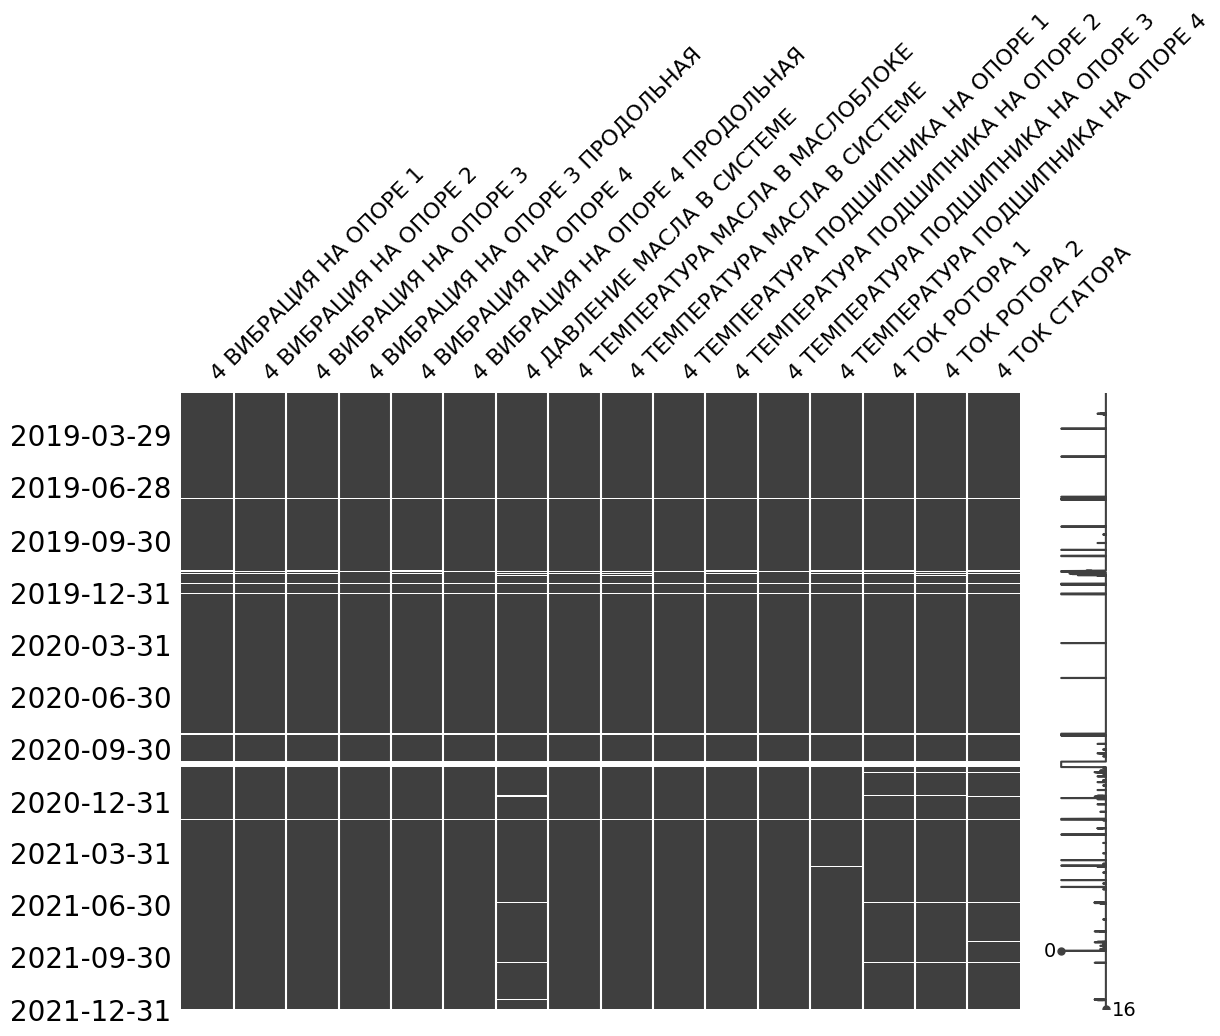

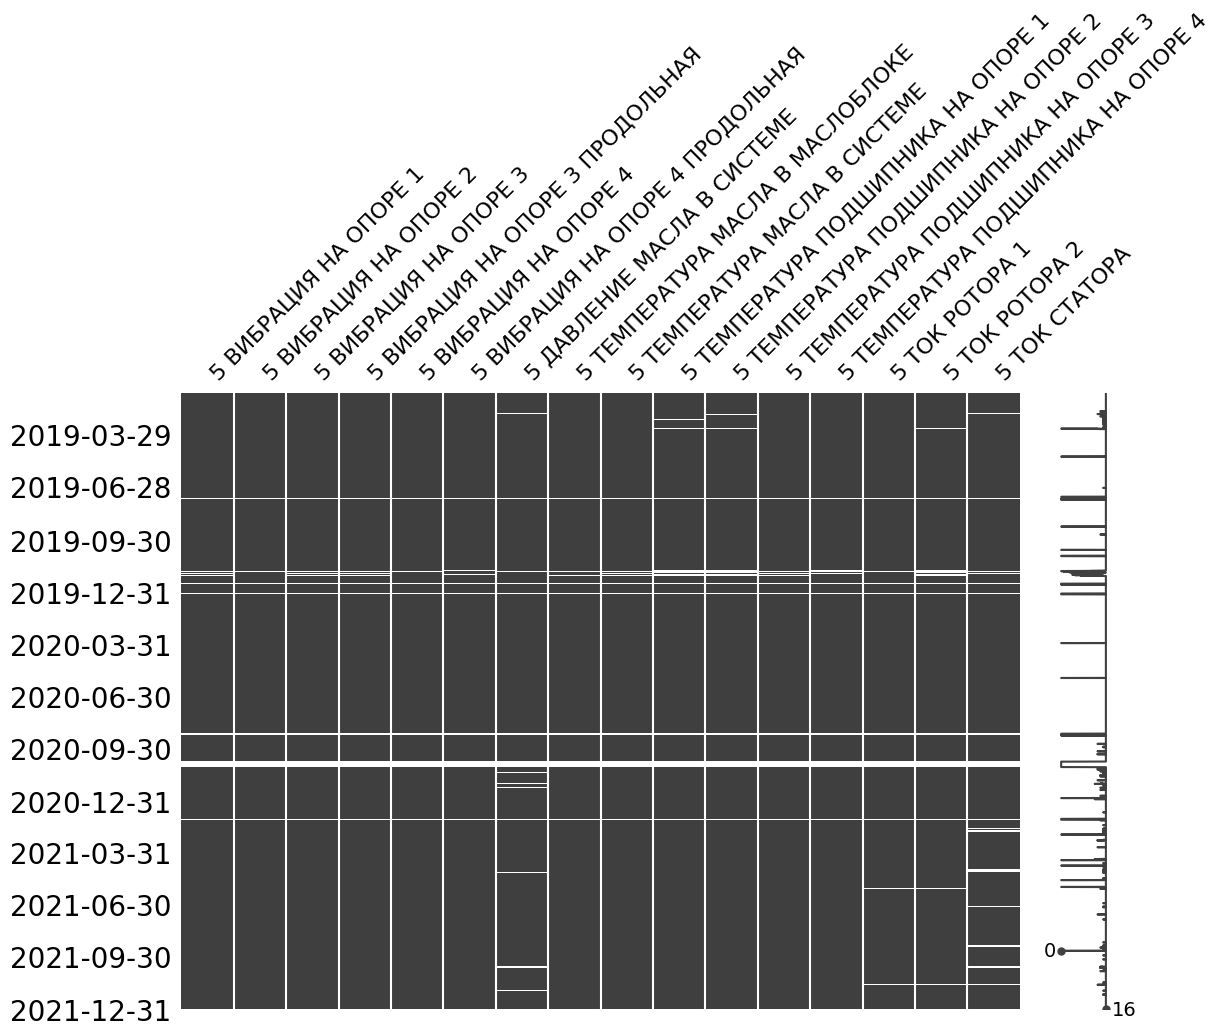

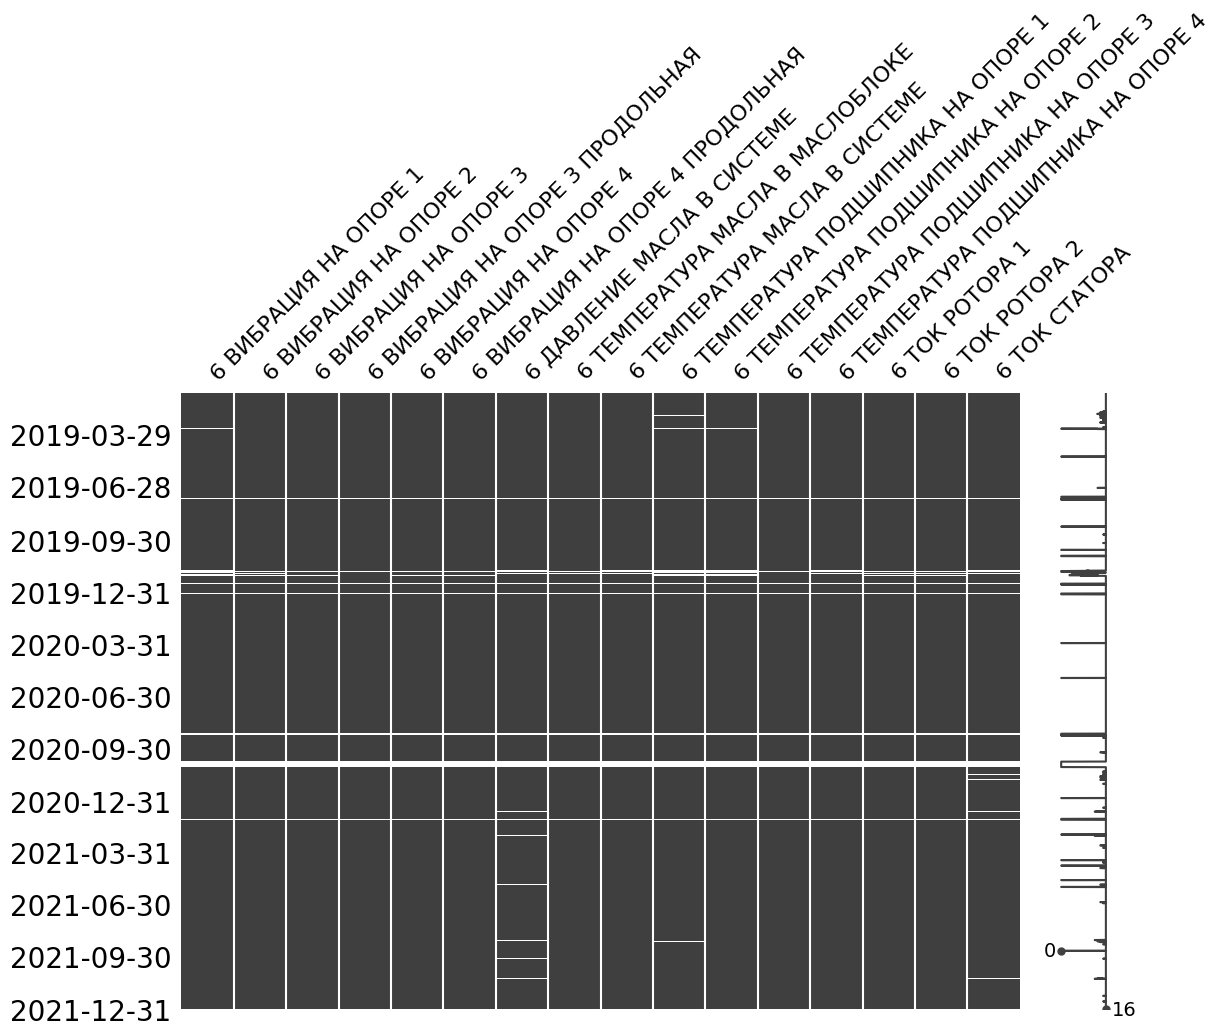

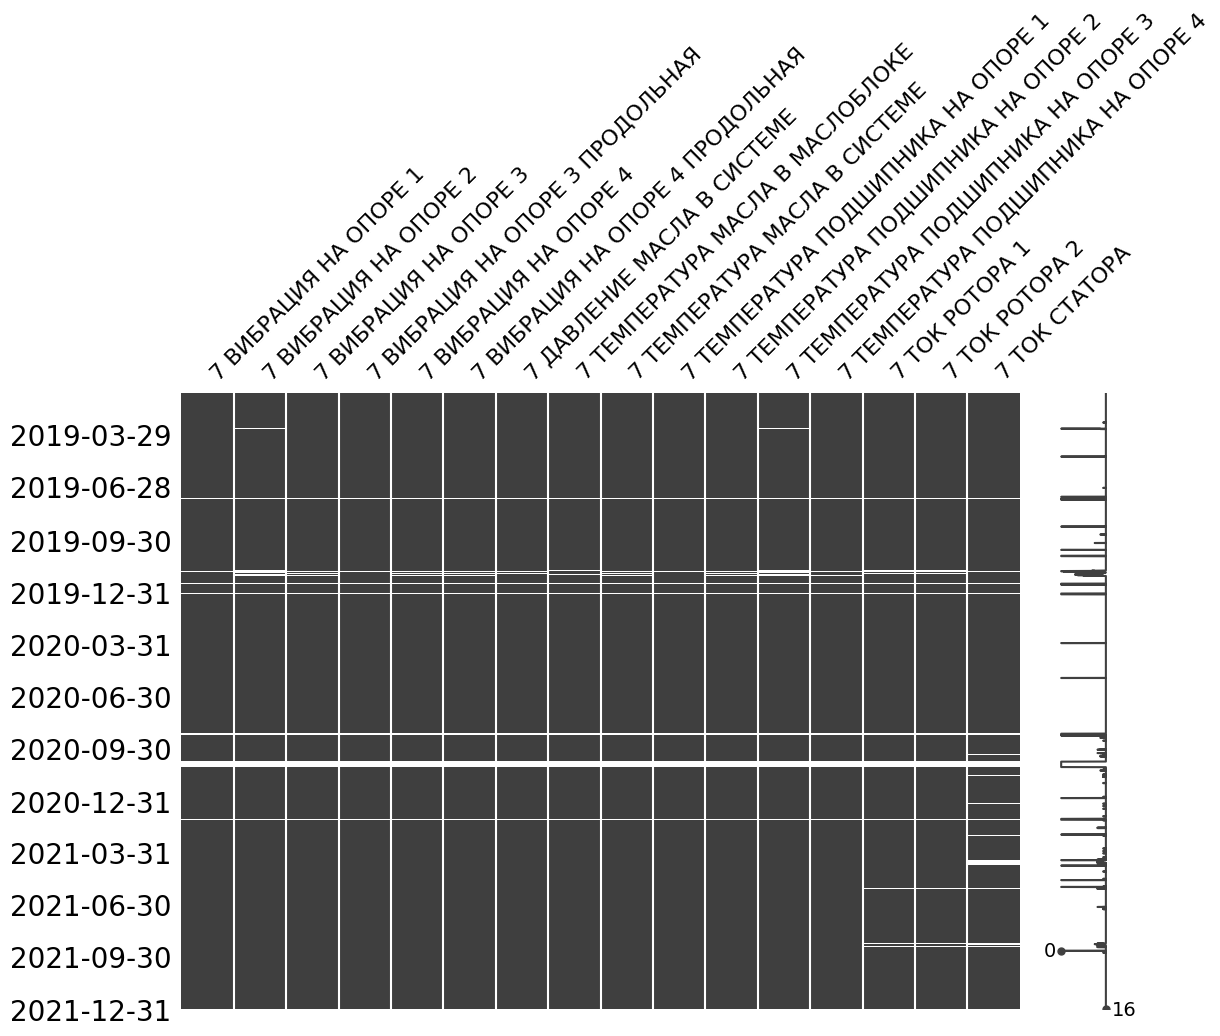

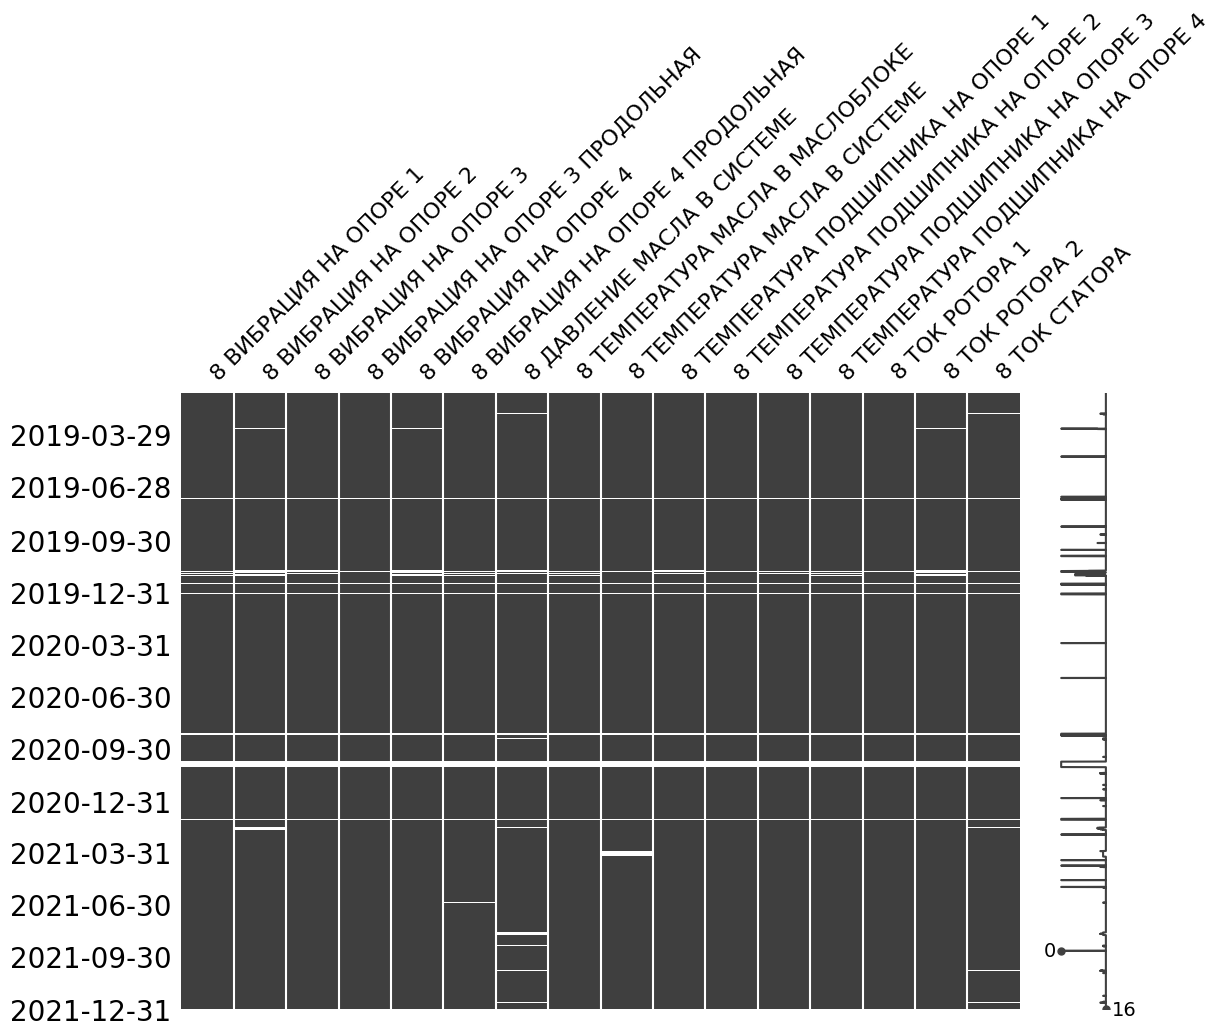

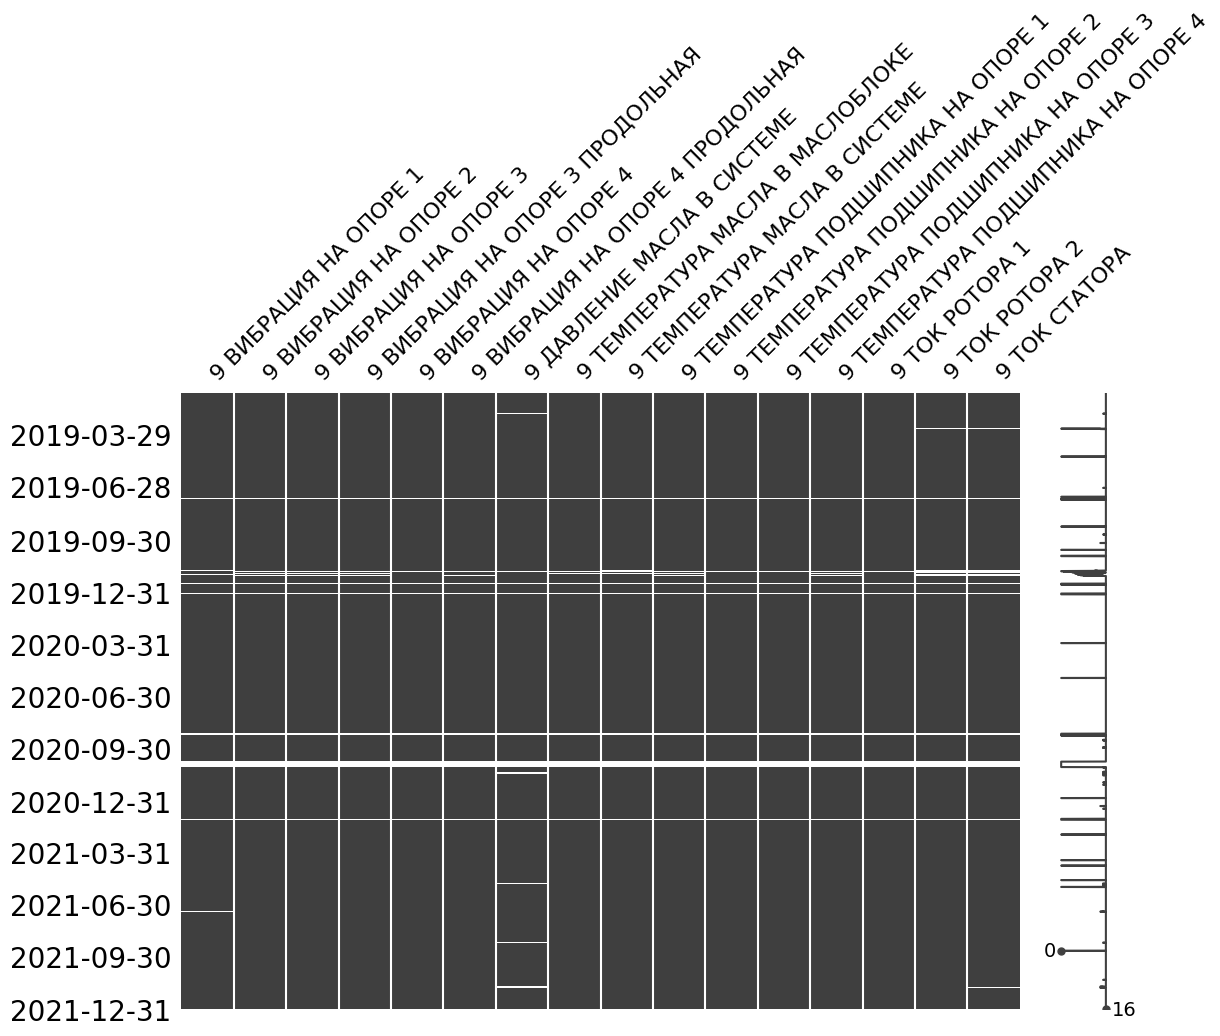

In [27]:
freq = "1H"
for equipment in range(4, 10):
  X_train = load_X(equipment, path=PATH).resample(freq).median()
  msno.matrix(X_train, freq='BQ', figsize=(12, 8));

#### 2.2.2. Пропуски в тестовой выборке

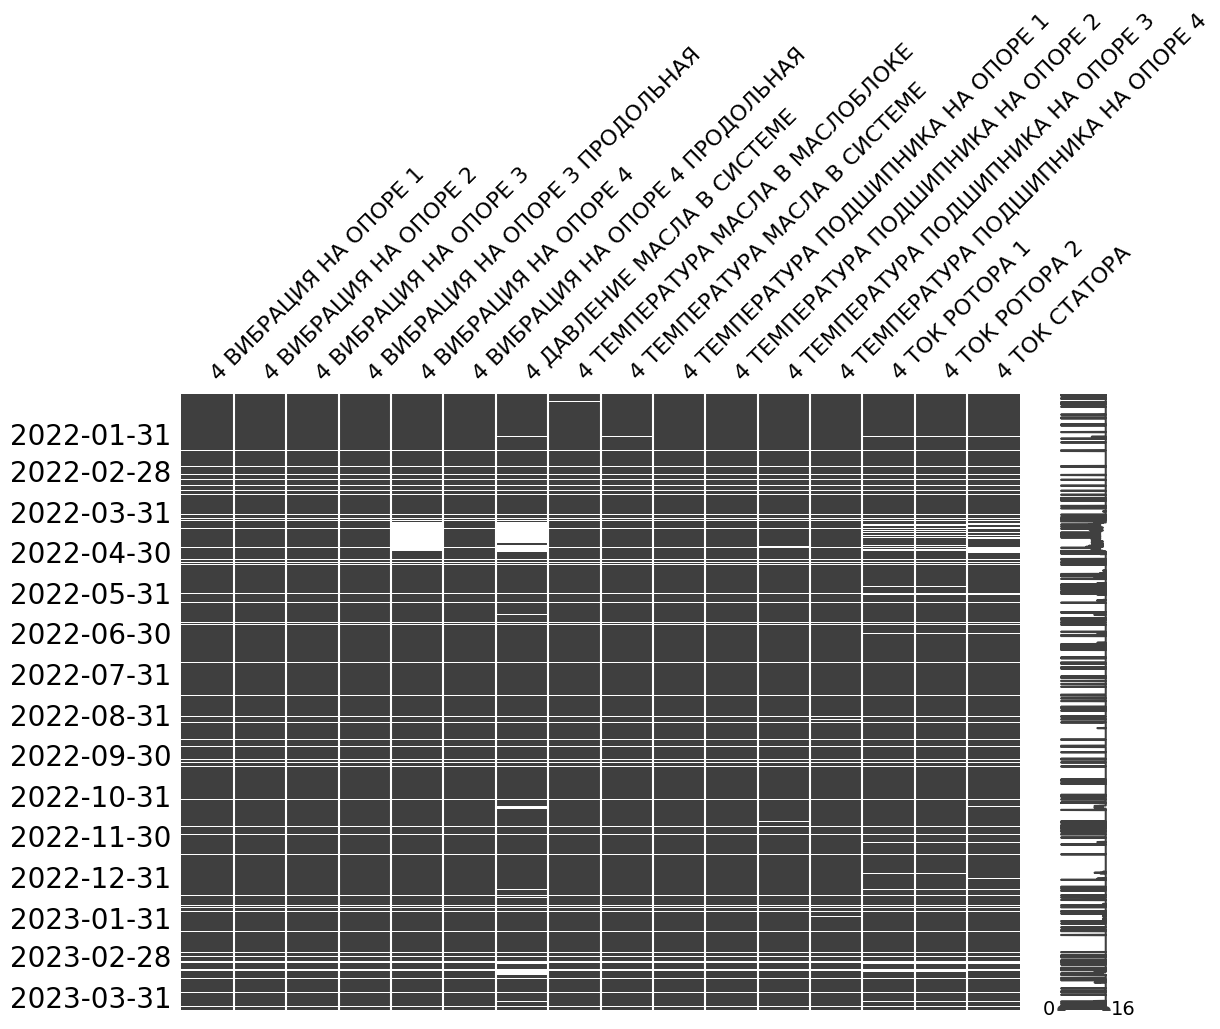

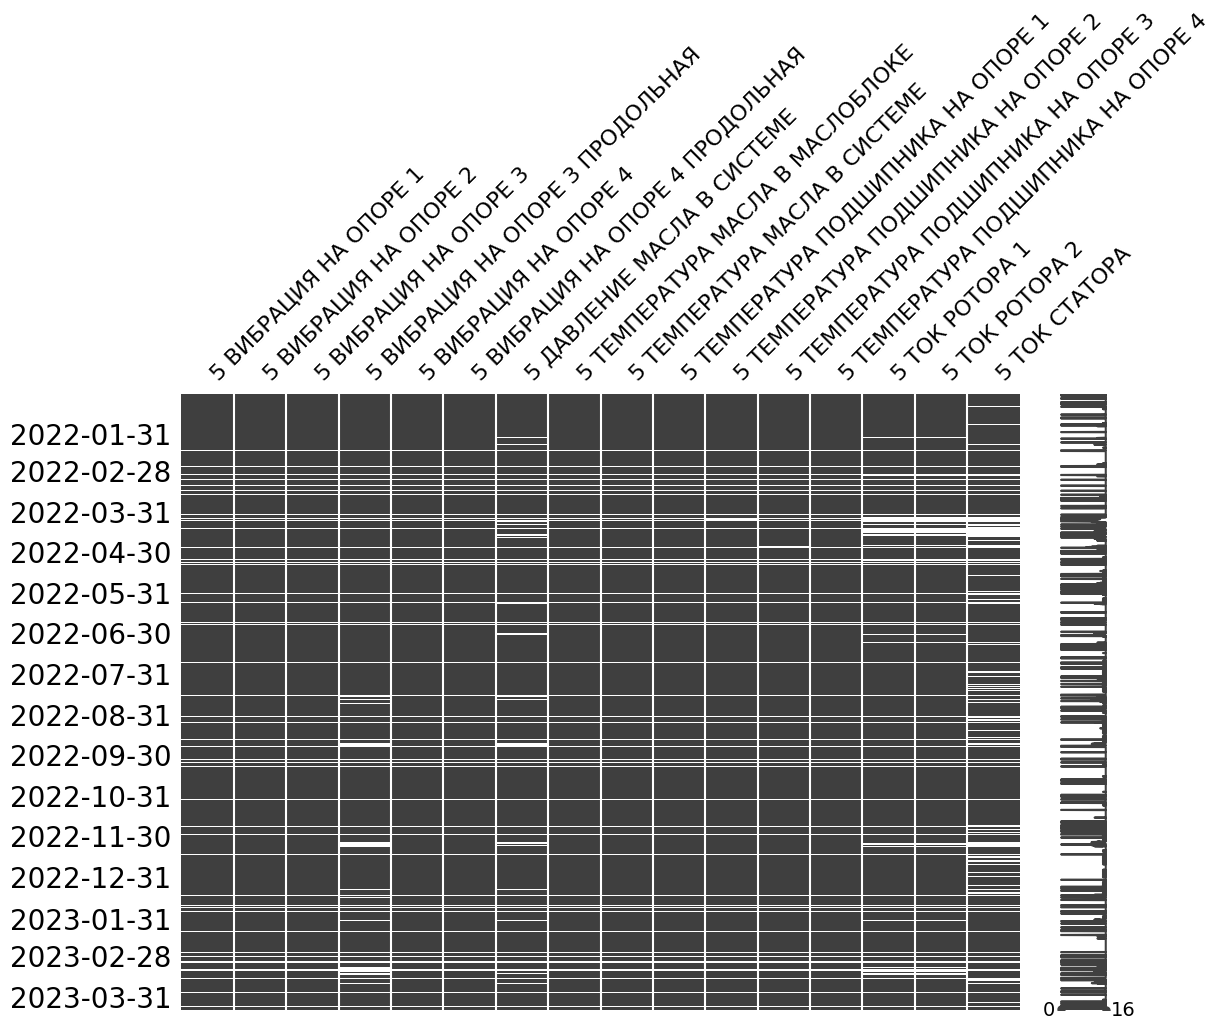

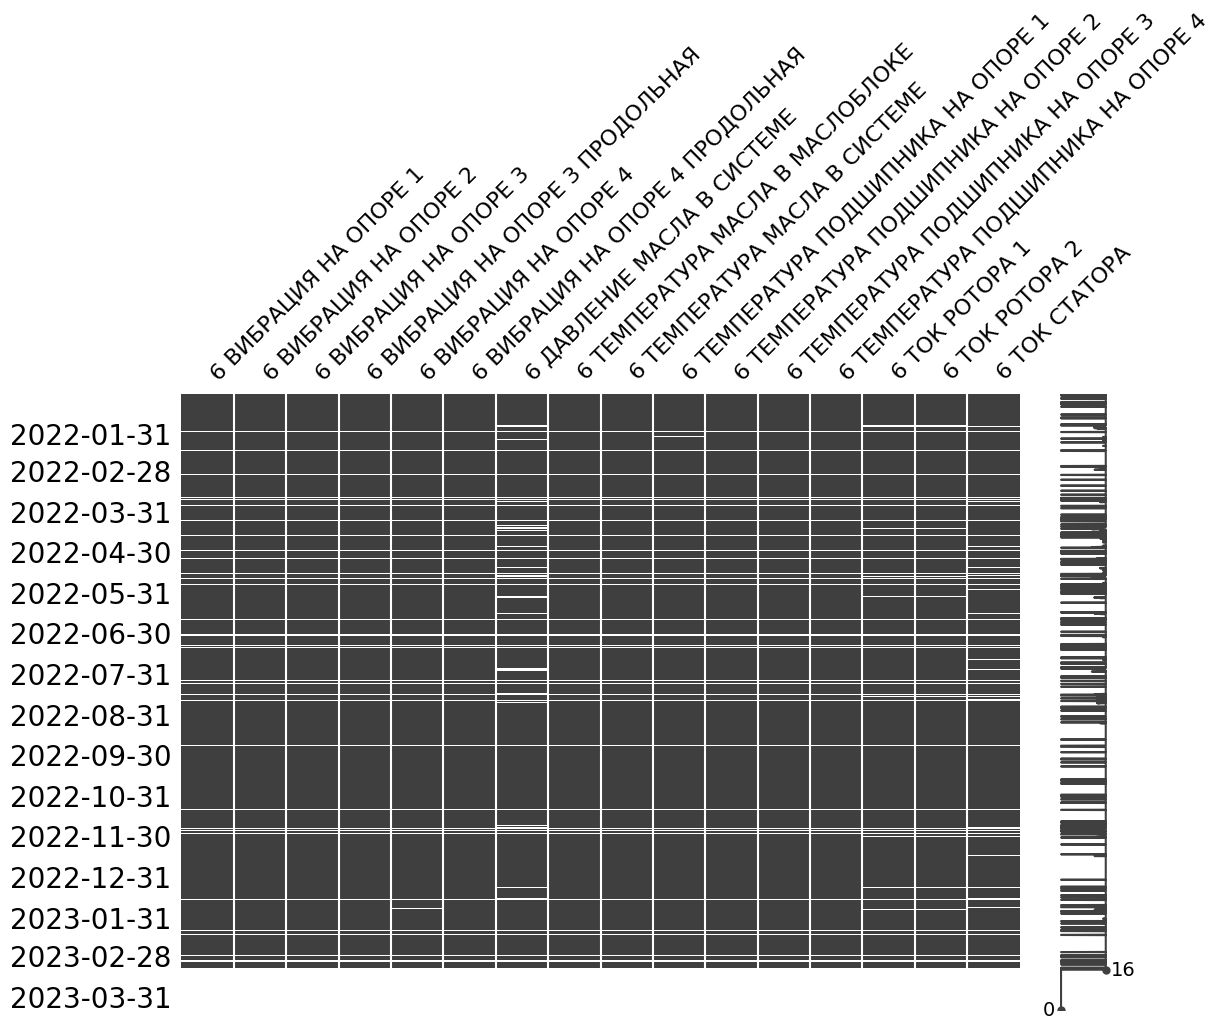

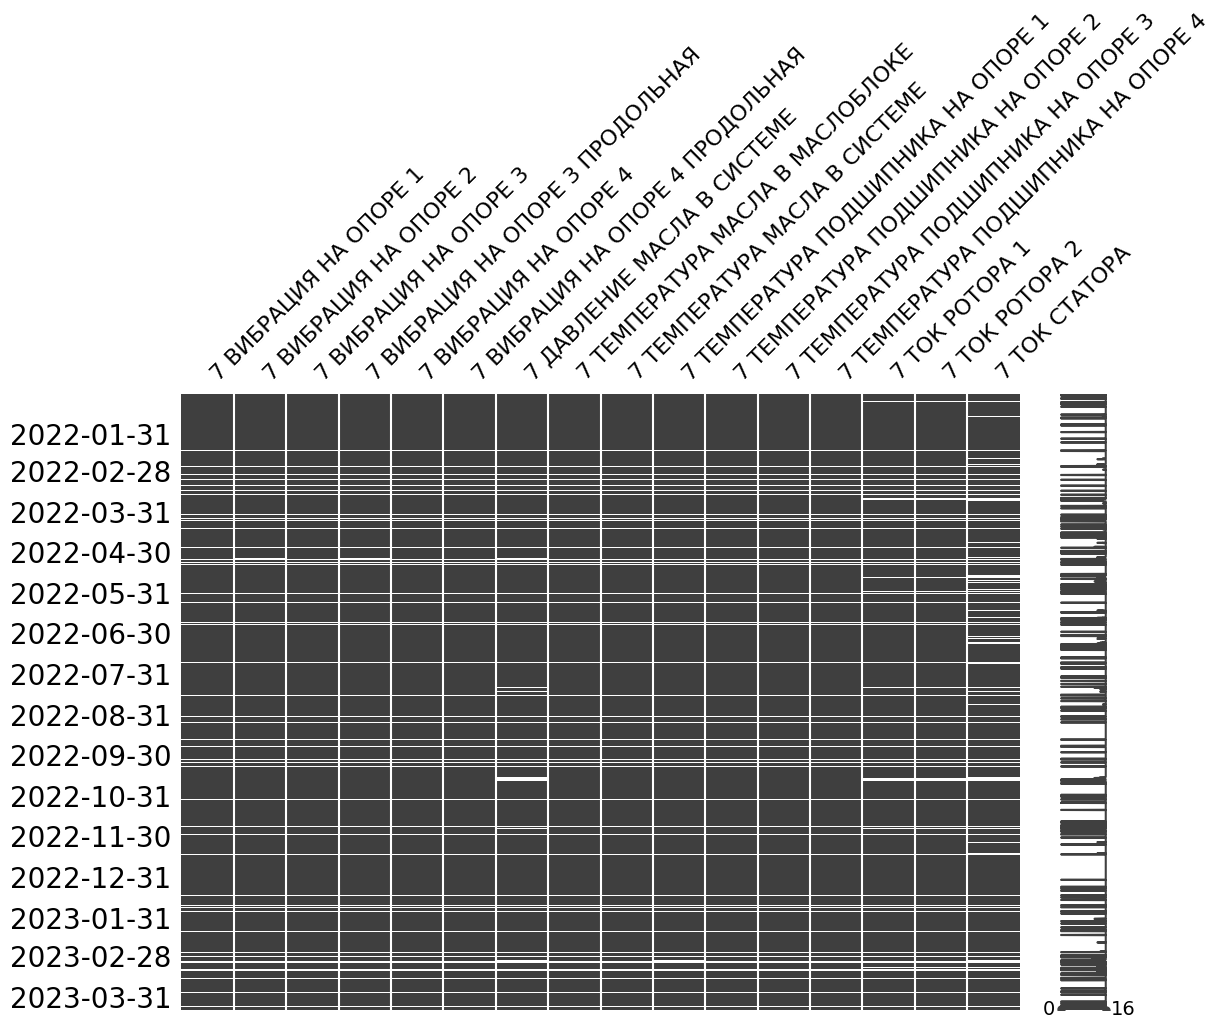

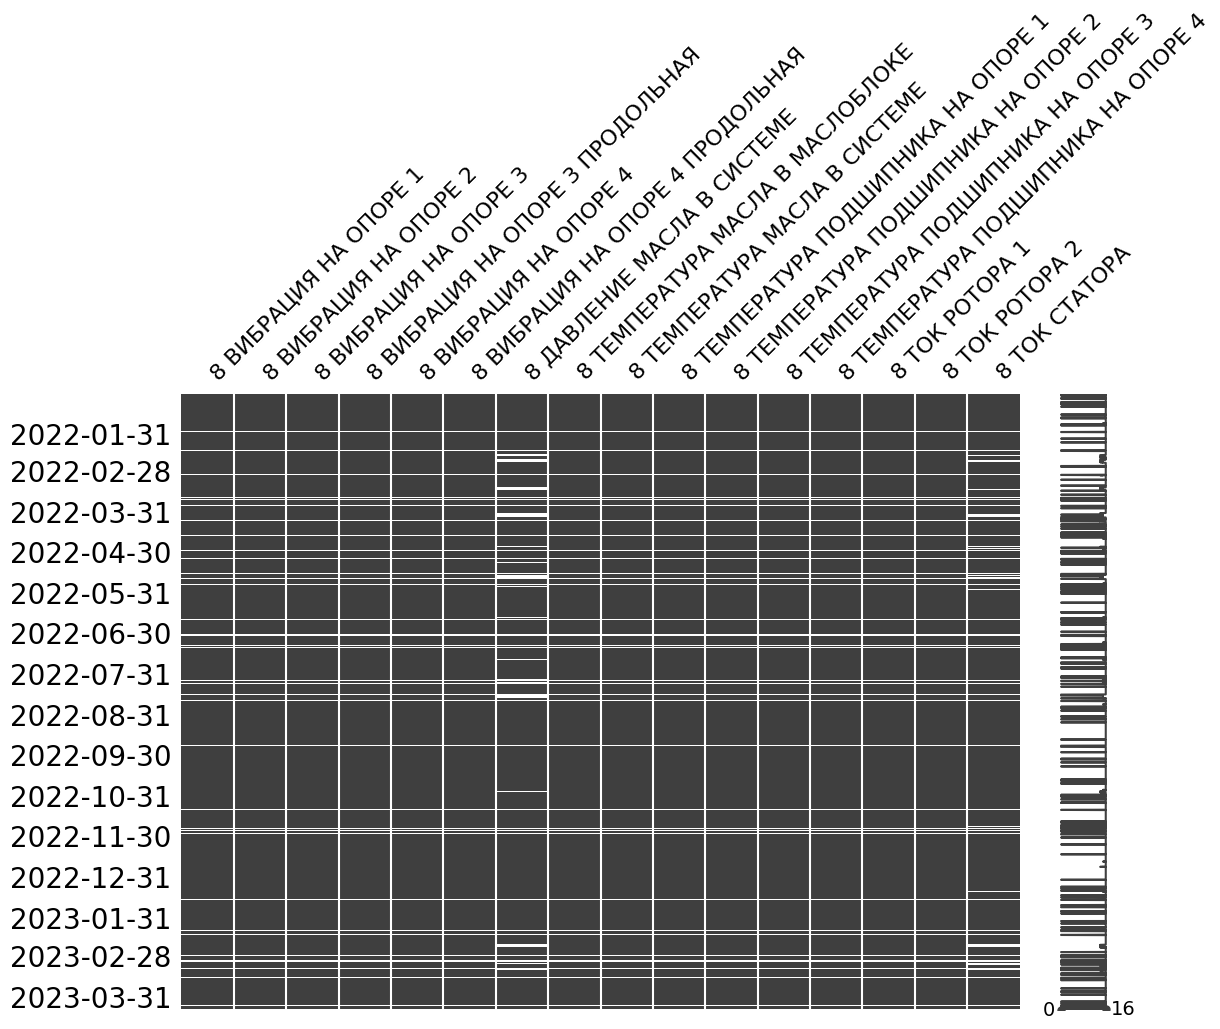

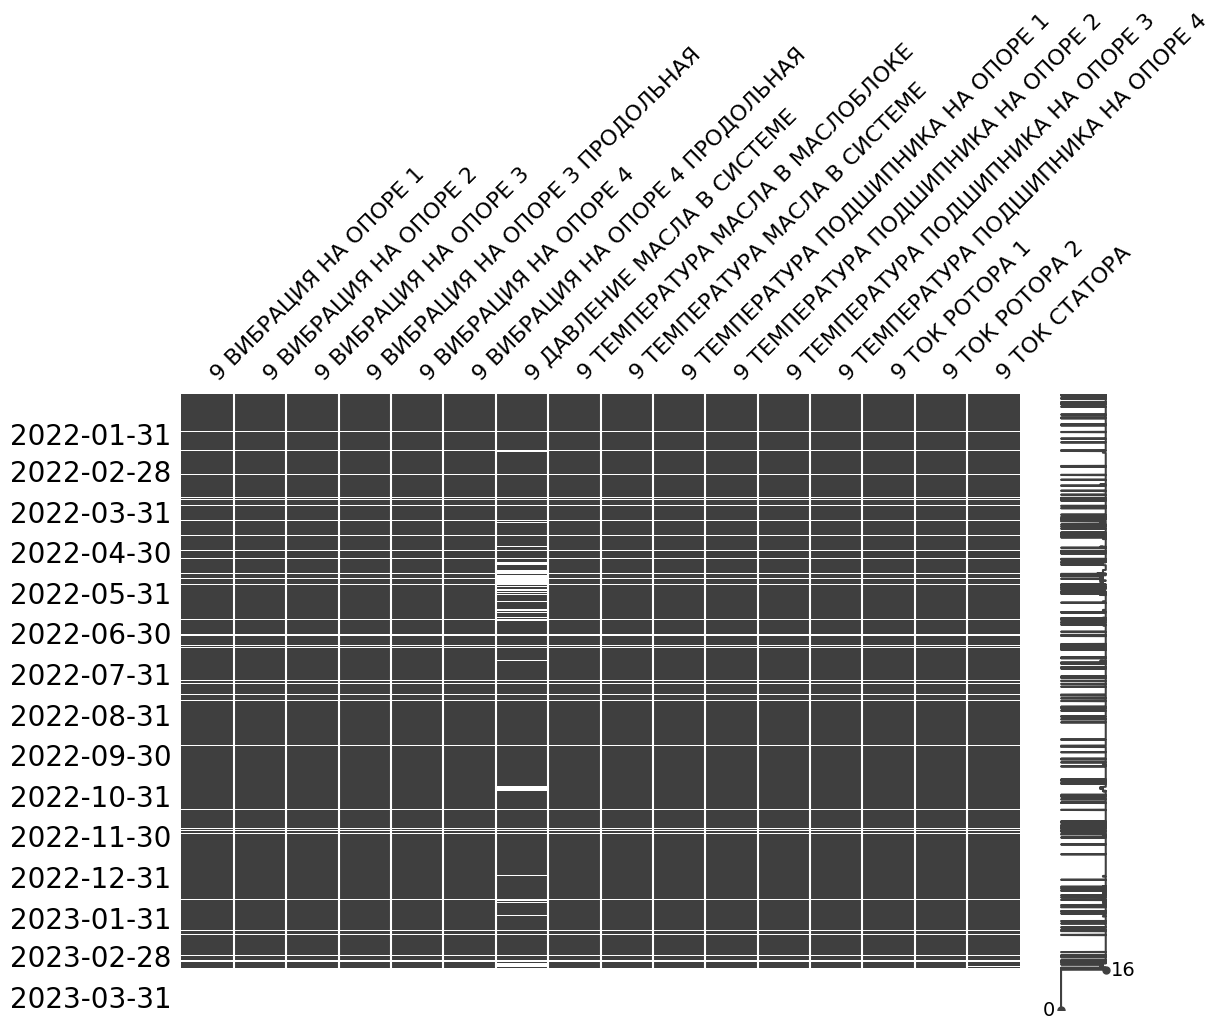

In [28]:
for equipment in range(4, 10):
  X_test = load_X(equipment, path=PATH, prefix='X_test').resample(freq).median()
  msno.matrix(X_test, freq='M', figsize=(12, 8));

### 2.3. Эталонные периоды для LSTM модели

In [29]:
ethalon_periods = select_ethalon_periods(messages, path=PATH)
ethalon_periods.columns = [col[2:] for col in X_train.columns] + ['equipment']
ethalon_periods.iloc[:, :-1].describe().T

count        mean         std       min  \
ВИБРАЦИЯ НА ОПОРЕ 1                8162.0    1.510534    0.819428  0.025000   
ВИБРАЦИЯ НА ОПОРЕ 2                8162.0    1.013187    0.847183  0.029900   
ВИБРАЦИЯ НА ОПОРЕ 3                8162.0    1.365702    0.720291  0.033972   
ВИБРАЦИЯ НА ОПОРЕ 3 ПРОДОЛЬНАЯ     8162.0    1.706995    0.793792  0.050000   
ВИБРАЦИЯ НА ОПОРЕ 4                8162.0    1.030026    0.529443  0.050611   
ВИБРАЦИЯ НА ОПОРЕ 4 ПРОДОЛЬНАЯ     8162.0    1.417060    0.876033  0.054500   
ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ           8162.0  160.071826   35.166159  0.000000   
ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ     8162.0   34.109534    7.342469  0.324000   
ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ        8162.0   24.085842   10.502587  0.000000   
ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1  8162.0   43.517676    8.019684  0.000000   
ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2  8162.0   44.051509    7.614066  0.000000   
ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3  8162.0   39.153824    6.775552  0.000000   
ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4  8162.0   48.122012    9.630049  0.000000   
ТОК РОТОРА 1                       8162.0  282.548503  120.016994  0.650000   
ТОК РОТОРА 2                       8162.0  282.548457  120.016979  0.650000   
ТОК СТАТОРА                        8162.0  338.592691  696.066680  0.000000   

                                          25%         50%         75%  \
ВИБРАЦИЯ НА ОПОРЕ 1                  0.886667    1.213333    2.364875   
ВИБРАЦИЯ НА ОПОРЕ 2                  0.556698    0.800000    1.010000   
ВИБРАЦИЯ НА ОПОРЕ 3                  0.677281    1.388750    1.749792   
ВИБРАЦИЯ НА ОПОРЕ 3 ПРОДОЛЬНАЯ       1.146667    1.572078    2.327500   
ВИБРАЦИЯ НА ОПОРЕ 4                  0.646719    1.058333    1.226667   
ВИБРАЦИЯ НА ОПОРЕ 4 ПРОДОЛЬНАЯ       0.730399    1.049167    1.896667   
ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ           134.487556  166.930839  175.823451   
ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ      29.090328   35.426250   38.940000   
ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ         15.955833   25.352500   32.315000   
ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1   40.236000   44.851036   48.676667   
ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2   39.952500   44.620000   48.883066   
ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3   35.923709   39.345000   42.929718   
ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4   42.595000   47.455000   56.385000   
ТОК РОТОРА 1                       203.970000  321.968625  376.723350   
ТОК РОТОРА 2                       203.970000  321.968625  376.722457   
ТОК СТАТОРА                        256.566708  263.338750  270.325417   

                                           max  
ВИБРАЦИЯ НА ОПОРЕ 1                   5.387500  
ВИБРАЦИЯ НА ОПОРЕ 2                   7.520000  
ВИБРАЦИЯ НА ОПОРЕ 3                   4.659167  
ВИБРАЦИЯ НА ОПОРЕ 3 ПРОДОЛЬНАЯ        8.098319  
ВИБРАЦИЯ НА ОПОРЕ 4                   3.491354  
ВИБРАЦИЯ НА ОПОРЕ 4 ПРОДОЛЬНАЯ        3.920000  
ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ            266.331000  
ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ       53.989000  
ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ          44.026320  
ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1    72.605000  
ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2    61.613473  
ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3    54.115000  
ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4    63.907750  
ТОК РОТОРА 1                        407.309500  
ТОК РОТОРА 2                        407.309500  
ТОК СТАТОРА                        6000.000000

n_components = 3
explained_variance = 0.864
variance explained by 3 components:  0.596 0.171 0.096 



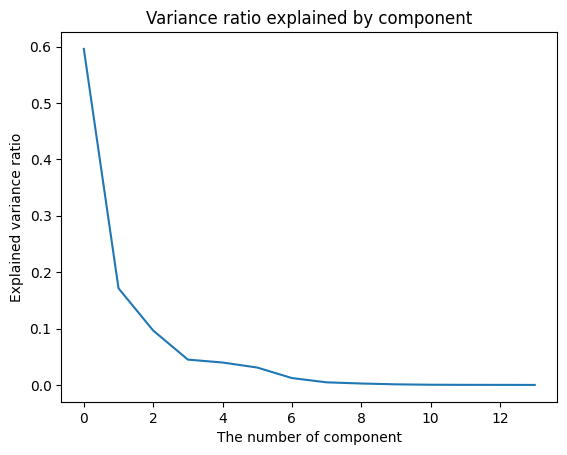

In [30]:
ethalon_dataset, scaler, pca = generate_ethalon_dataset(
    messages, path=PATH, plot=True,
)

In [31]:
ethalon_dataset.shape

(7062, 50, 3)

In [32]:
batch = 32

n = np.random.choice(len(ethalon_dataset), batch)
ethalon_dataset[n, :, :].shape

(32, 50, 3)

### 2.4. Неплановые остановки

In [33]:
M1_dataset, M1_time_label = get_M1_dataset_and_time_label(
    scaler,
    pca,
    messages,
    path=PATH
)

M1_dataset.shape, len(M1_time_label)

((1584, 23, 3), 1584)

Для калибровки и валидации на предмет распознавания остановок разобьем данные на валидационные и тестовые.

### 2.5. Аномалии

In [34]:
def plot_anomalies(y):
  a = y.sum(axis=0)
  msno.matrix(y.loc[:, a[a > 0].index.tolist()], freq='BQ', figsize=(15, 6));

#### Эксгаустер 4


---------- Эксгаустер 4 ----------
M3_dataset.shape = (17890, 50, 16)


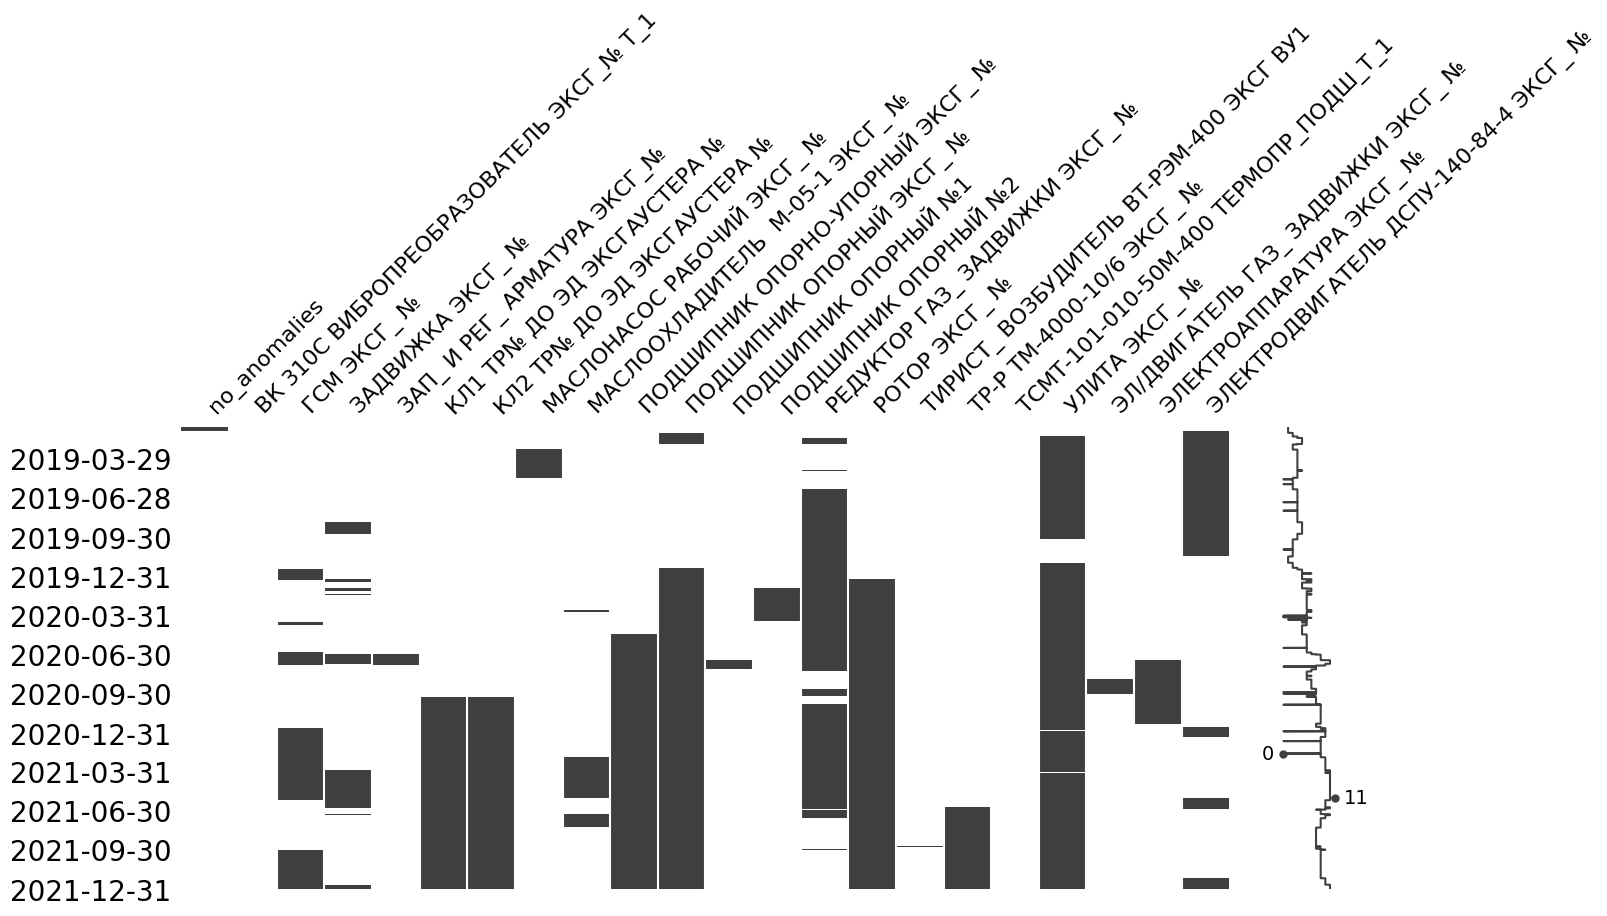

In [35]:
equipment = 4
M3_dataset = get_M3_dataset(equipment, messages, path=PATH,)
print(f'---------- Эксгаустер {equipment} ----------')
print(f'M3_dataset.shape = {M3_dataset.shape}')

y = generate_targets(equipment, messages)
plot_anomalies(y)

#### Эксгаустер 5

---------- Эксгаустер 5 ----------
M3_dataset.shape = (25201, 50, 16)


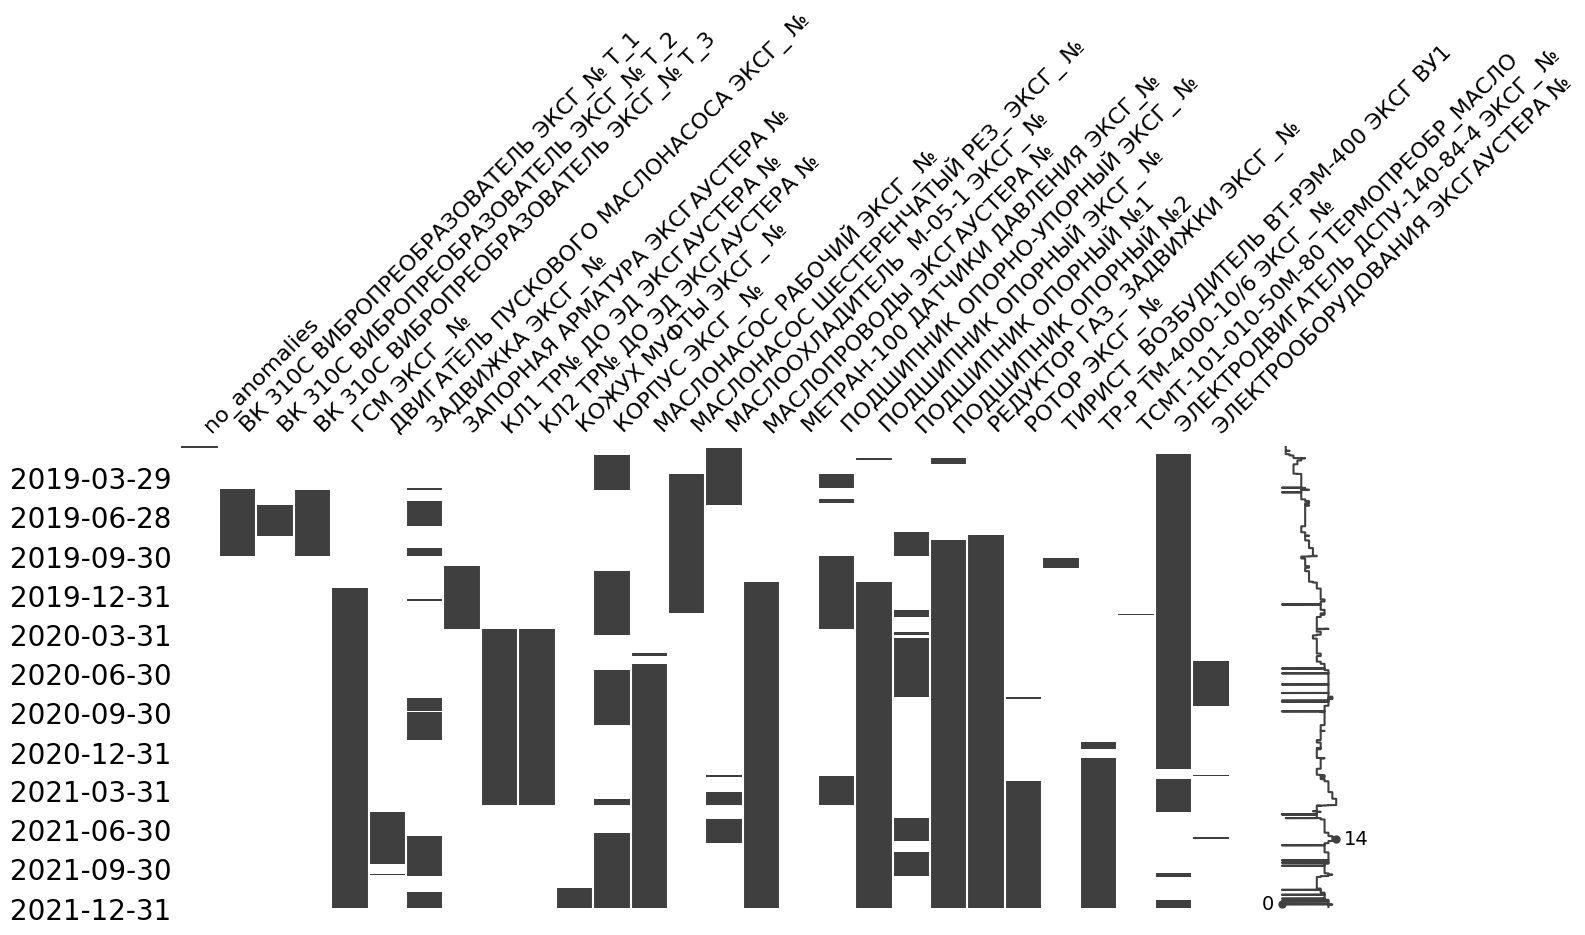

In [36]:
equipment = 5
M3_dataset = get_M3_dataset(equipment, messages, path=PATH,)
print(f'---------- Эксгаустер {equipment} ----------')
print(f'M3_dataset.shape = {M3_dataset.shape}')

y = generate_targets(equipment, messages)
plot_anomalies(y)

#### Эксгаустер 6

---------- Эксгаустер 6 ----------
M3_dataset.shape = (19576, 50, 16)


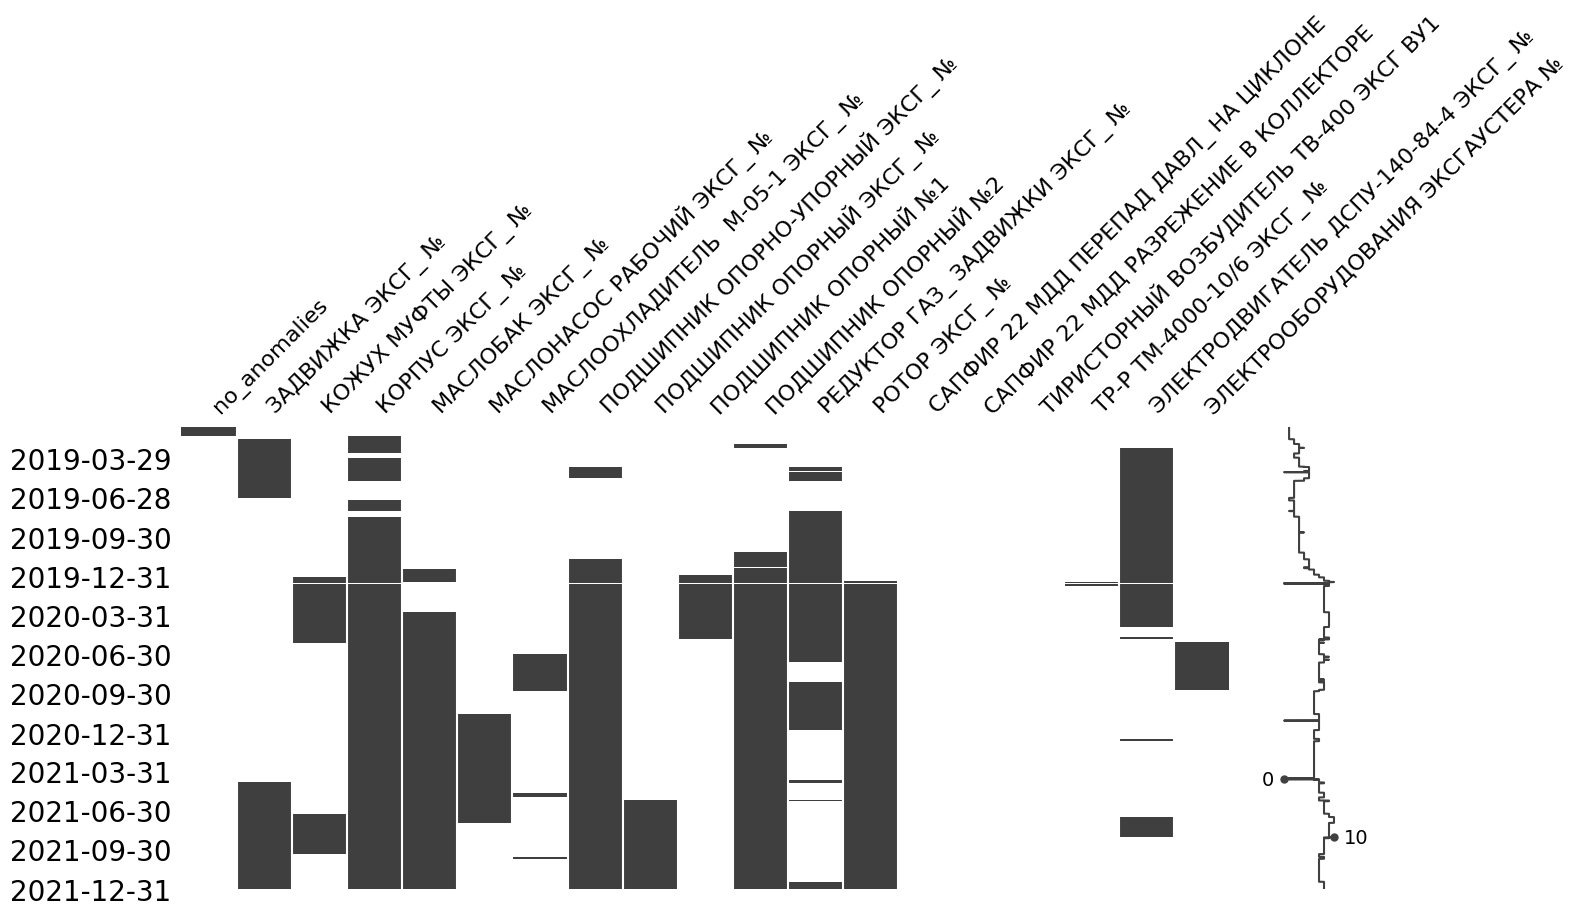

In [37]:
equipment = 6
M3_dataset = get_M3_dataset(equipment, messages, path=PATH,)
print(f'---------- Эксгаустер {equipment} ----------')
print(f'M3_dataset.shape = {M3_dataset.shape}')

y = generate_targets(equipment, messages)
plot_anomalies(y)

#### Эксгаустер 7

---------- Эксгаустер 7 ----------
M3_dataset.shape = (19018, 50, 16)


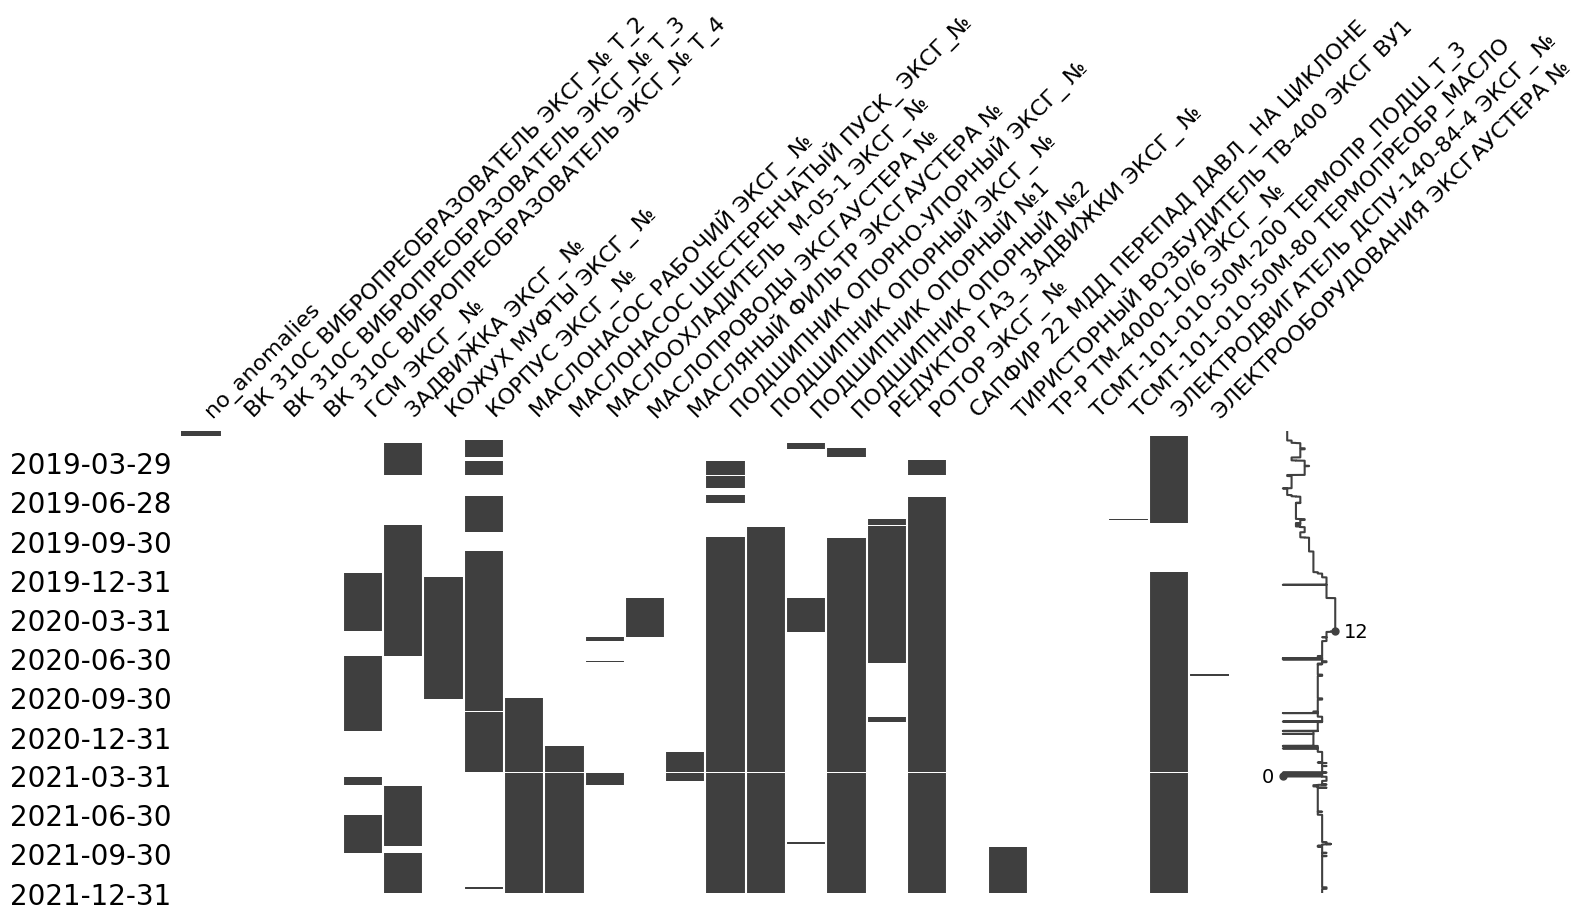

In [38]:
equipment = 7
M3_dataset = get_M3_dataset(equipment, messages, path=PATH,)
print(f'---------- Эксгаустер {equipment} ----------')
print(f'M3_dataset.shape = {M3_dataset.shape}')

y = generate_targets(equipment, messages)
plot_anomalies(y)

#### Эксгаустер 8

---------- Эксгаустер 8 ----------
M3_dataset.shape = (24268, 50, 16)


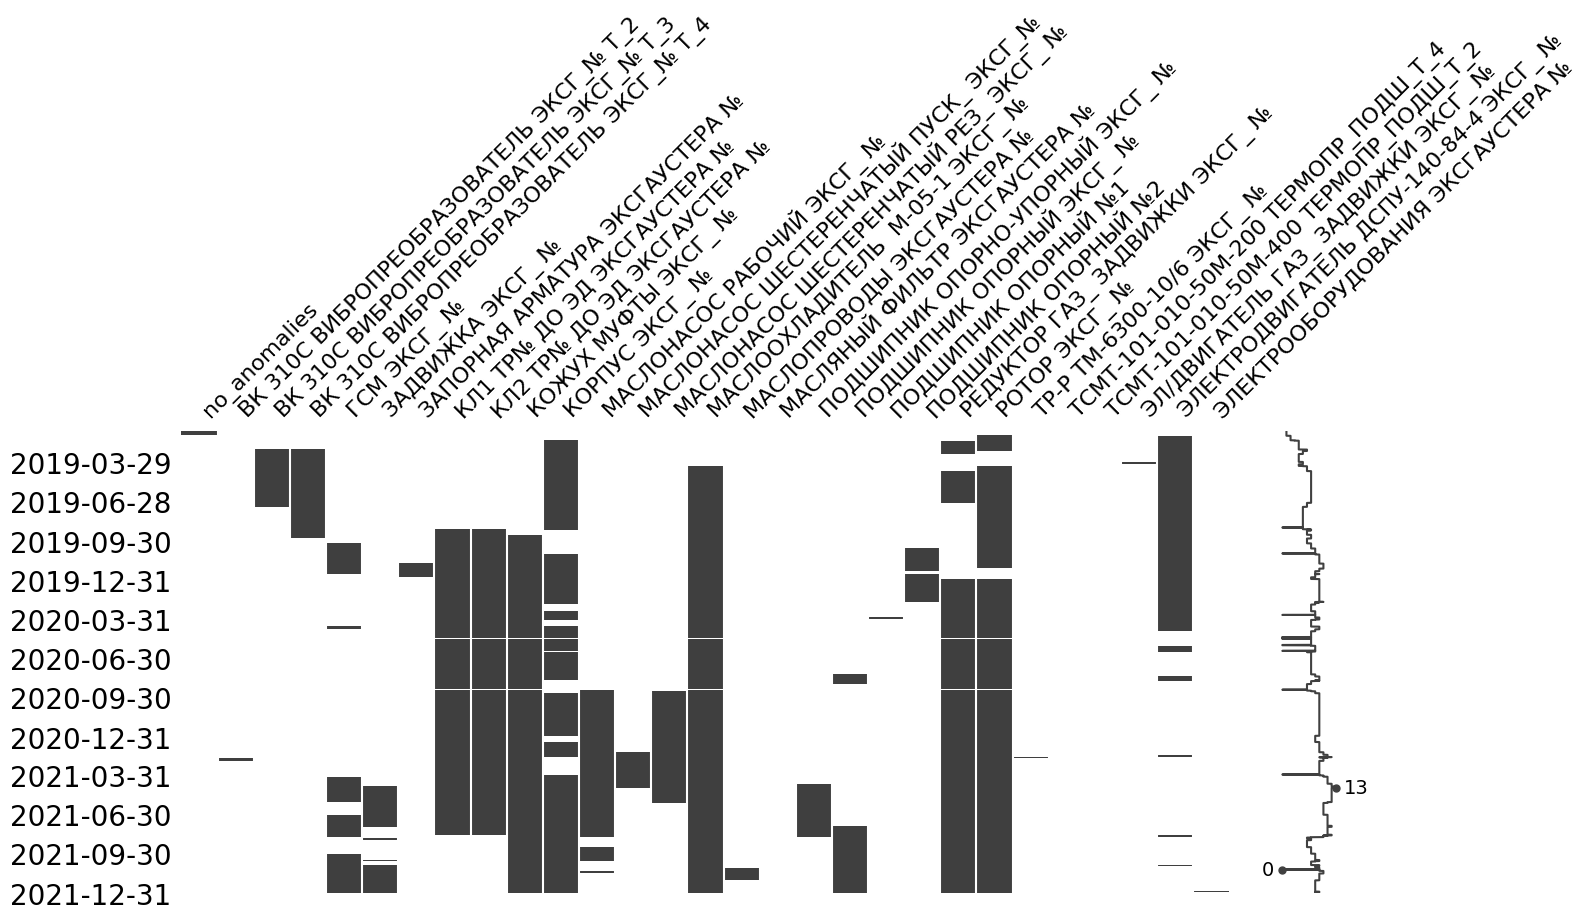

In [39]:
equipment = 8
M3_dataset = get_M3_dataset(equipment, messages, path=PATH,)
print(f'---------- Эксгаустер {equipment} ----------')
print(f'M3_dataset.shape = {M3_dataset.shape}')

y = generate_targets(equipment, messages)
plot_anomalies(y)

#### Эксгаустер 9

---------- Эксгаустер 9 ----------
M3_dataset.shape = (25804, 50, 16)


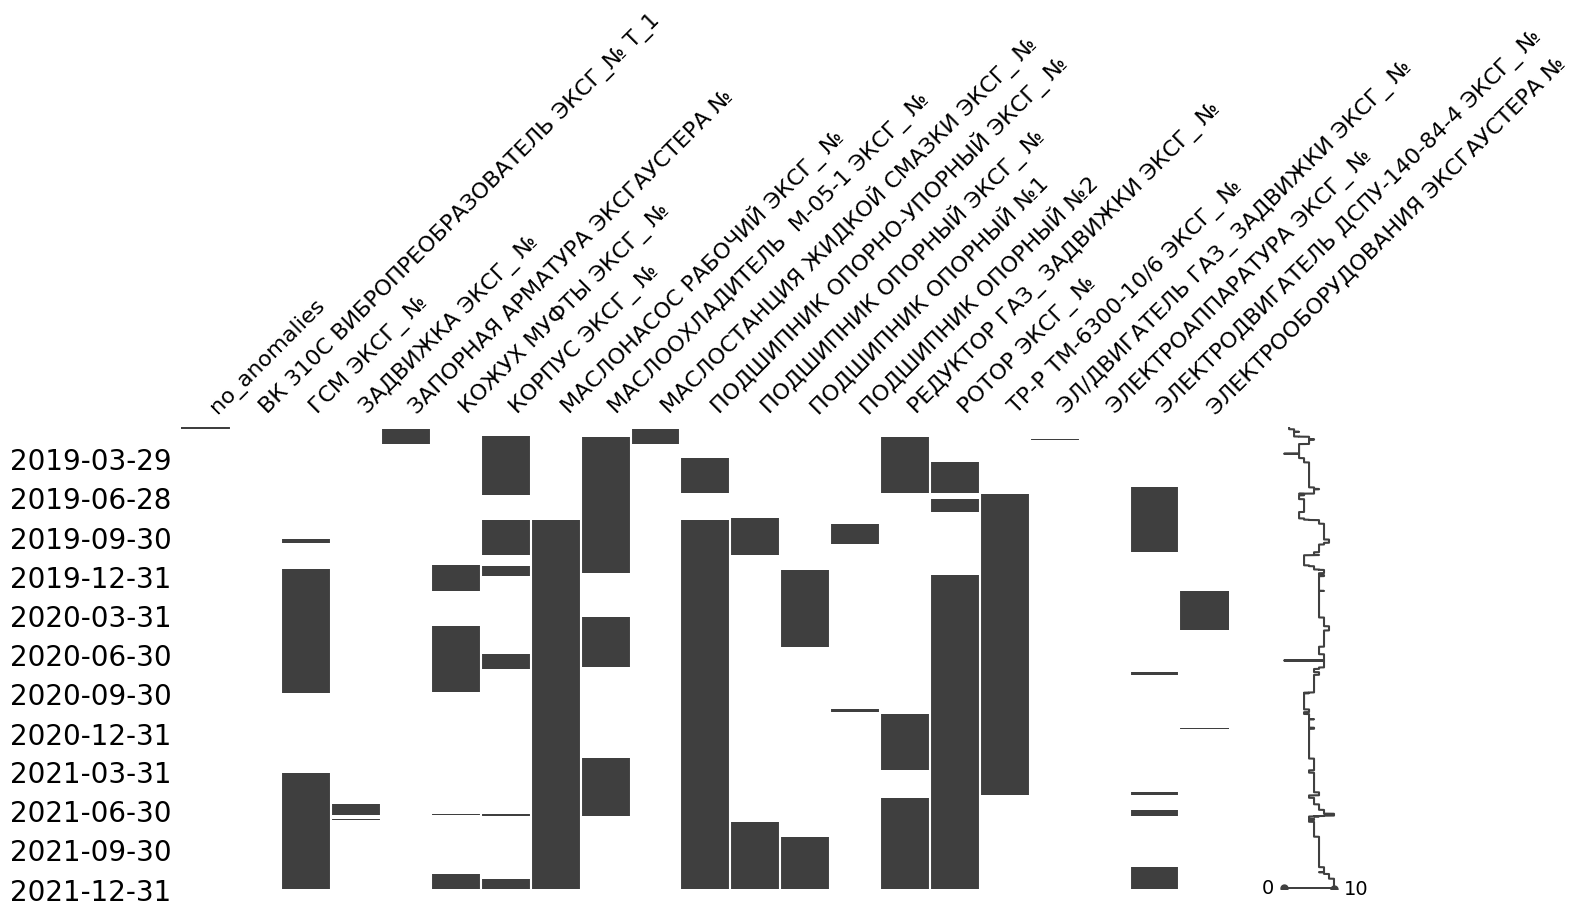

In [40]:
equipment = 9
M3_dataset = get_M3_dataset(equipment, messages, path=PATH,)
print(f'---------- Эксгаустер {equipment} ----------')
print(f'M3_dataset.shape = {M3_dataset.shape}')

y = generate_targets(equipment, messages)
plot_anomalies(y)

### 2.6. Тестовая выборка

В наборе сигналов тестовой выборки (X_test) присутствуют интервалы с пропущенными значениями. Список интервалов предоставлен в test_intervals. Для этих интервалов необходимо предсказать наличие неисправности.

В случае предсказанной неисправности, определить тип и время начала развития и наступления неисправности.


In [41]:
test_intervals = test_intervals.sort_values(by='start').reset_index(drop=True)
print(f'test_intervals.shape = {test_intervals.shape}\n')
test_intervals.head()

test_intervals.shape = (189, 4)



start              finish  machine  tm
0 2022-01-01 10:54:53 2022-01-01 16:43:39      NaN NaN
1 2022-01-02 12:26:42 2022-01-02 15:16:06      NaN NaN
2 2022-01-04 12:06:07 2022-01-04 15:04:34      NaN NaN
3 2022-01-04 20:13:57 2022-01-05 00:19:40      NaN NaN
4 2022-01-07 09:05:16 2022-01-07 14:05:15      NaN NaN

In [42]:
test_intervals['start'].min(), test_intervals['finish'].max()

(Timestamp('2022-01-01 10:54:53'), Timestamp('2023-04-20 23:58:07'))

In [43]:
(test_intervals['finish'] - test_intervals['start']).describe()

count                          189
mean     0 days 04:59:35.428571428
std      0 days 03:06:42.587346539
min                0 days 02:42:34
25%                0 days 03:38:37
50%                0 days 04:13:31
75%                0 days 05:05:08
max                1 days 00:58:29
dtype: object

Тестовый период - с 01.01.2022 по 20.04.2023 включительно. В среднем, интервал предсказания составляет 5 часов, медиана - 4 часа 13 минут. Максимальный горизонт предсказания - 25 часов.

#### 2.6.1. Объединение тестовых интервалов.

* Случаи, когда текущий период заканчивается раньше предыдущего.

In [44]:
for i in range(1, len(test_intervals)):
  t_start_prev = test_intervals.loc[i-1, 'start']
  t_end_prev = test_intervals.loc[i-1, 'finish']

  t_start = test_intervals.loc[i, 'start']
  t_end = test_intervals.loc[i, 'finish']

  if t_end_prev >= t_end:
    print(f'time difference:   {t_end_prev - t_start}  t_end_prev: {t_end_prev} t_start: {t_start}')
    print(f'new period length: {t_end_prev - t_start_prev}\n')

time difference:   0 days 03:57:38  t_end_prev: 2022-11-22 05:38:25 t_start: 2022-11-22 01:40:47
new period length: 0 days 04:22:54

time difference:   0 days 05:08:31  t_end_prev: 2023-01-10 14:08:44 t_start: 2023-01-10 09:00:13
new period length: 0 days 06:10:21



* Случаи, когда тестовый период начинается до окончания предыдущего, а заканчивается после.

In [45]:
for i in range(1, len(test_intervals)):
  t_start_prev = test_intervals.loc[i-1, 'start']
  t_end_prev = test_intervals.loc[i-1, 'finish']

  t_start = test_intervals.loc[i, 'start']
  t_end = test_intervals.loc[i, 'finish']

  if (t_start < t_end_prev) & (t_end_prev < t_end): #<= pd.Timedelta(23, 'H'):
    print(f'time difference:   {t_end_prev - t_start}  t_end_prev: {t_end_prev} t_start: {t_start}')
    print(f'new period length: {t_end - t_start_prev}\n')

time difference:   0 days 02:39:29  t_end_prev: 2022-06-22 06:41:29 t_start: 2022-06-22 04:02:00
new period length: 0 days 16:25:46

time difference:   0 days 00:08:29  t_end_prev: 2022-07-10 10:07:27 t_start: 2022-07-10 09:58:58
new period length: 0 days 08:05:33

time difference:   0 days 00:00:06  t_end_prev: 2022-09-01 07:33:38 t_start: 2022-09-01 07:33:32
new period length: 0 days 13:33:52

time difference:   0 days 01:14:30  t_end_prev: 2023-01-10 13:30:37 t_start: 2023-01-10 12:16:07
new period length: 0 days 07:28:58



* Объединим тестовые интервалы.

In [46]:
test_intervals = combine_test_intervals(test_intervals)
test_intervals.shape

(183, 4)

#### 2.6.2. Пропуски в данных для инференса.

In [47]:
len_input_period = 23
input_period = pd.Timedelta(len_input_period, "H")

s = 0
for i in range(1, len(test_intervals)):
  if test_intervals.loc[i, 'start'] - input_period < test_intervals.loc[i-1, 'finish']:
    s += 1
s

64

В тестовых интервалах в 64 случаях из 183 периоды, для которых нужно сделать предсказания, одновременно являются входящими периодами для LSTM модели на инференсе.

В реальной жизни информация для инференса, как правило, доступна, но в нашем случае информация пропущена. Заполним ее c помощью .bfill().ffill().

#### 2.6.3. Интервалы за пределами горизонта предсказания модели.

In [48]:
equipment = 4
freq = "1H"
input_period = pd.Timedelta(23, "H")
X_test = load_X(equipment, path=PATH, prefix="X_test").resample(freq).median()

for t1  in test_intervals['start']:
  t0 = t1 - input_period
  a = X_test.loc[t0:t1, :]
  if a.shape[0] != input_period // pd.Timedelta(freq):
    print(f'{t1} {a.shape}')

2022-01-01 10:54:53 (11, 16)
2023-04-10 18:08:25 (5, 16)
2023-04-18 02:28:43 (0, 16)
2023-04-20 16:41:58 (0, 16)


Предсказания на интервалы после 2023-04-10 18:00 в рамках почасовой модели делаться не будут. Для них будет разработана подневная модель.

In [49]:
all_test_periods = generate_test_dataset(test_intervals, path=PATH)

for equipment in range(4, 10):
  print(all_test_periods[equipment].shape)

(179, 23, 16)
(179, 23, 16)
(179, 23, 16)
(179, 23, 16)
(179, 23, 16)
(179, 23, 16)
